# Supervised Learning for Best Model

In [1]:
import numpy as np
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import pandas as pd
from dotenv import load_dotenv
pd.set_option('display.max_columns', None)
import os
import json
import boto3
import datetime
import contractions
from collections import Counter
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
import mlflow
from mlflow.tracking import MlflowClient
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/chuby/Desktop/programming/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

In [2]:
load_dotenv()
aws_secret_access_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
aws_access_key_id = os.environ.get("AWS_ACCESS_KEY_ID")
os.environ.get("MLFLOW_HTTP_REQUEST_TIMEOUT")

EXPERIMENT_NAME = "sentiment-hate-experiment"
TRACKING_SERVER_HOST = '3.82.98.49'
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")
# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use it to run the experiments
try:
    # Create experiment
    experiment_id = client.create_experiment(EXPERIMENT_NAME)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
    mlflow.set_experiment(experiment_id=experiment_id)

print(mlflow.get_tracking_uri())

http://3.82.98.49:5000


In [3]:
mlflow.search_experiments()

[<Experiment: artifact_location='s3://mlflow-artifact-store-remote/1', creation_time=1677836216975, experiment_id='1', last_update_time=1677836216975, lifecycle_stage='active', name='sentiment-hate-experiment', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-store-remote/0', creation_time=1677778440437, experiment_id='0', last_update_time=1677778440437, lifecycle_stage='active', name='Default', tags={}>]

In [4]:
print(f"Tracking URI: '{mlflow.get_tracking_uri()}'")
print(f"Artifacts URI: '{mlflow.get_artifact_uri()}'")

Tracking URI: 'http://3.82.98.49:5000'
Artifacts URI: 's3://mlflow-artifact-store-remote/1/f15ab16833f344f8aba02e300a399847/artifacts'


In [5]:
train_data='labelled.parquet.gzip'
unlabelled_data='unlabelled.parquet.gzip'

unlabelled_data = pd.read_parquet(os.path.join(os.getcwd(),unlabelled_data))
labelled_data = pd.read_parquet(os.path.join(os.getcwd(),train_data))

In [6]:
unlabelled_data.info()
unlabelled_data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 0 to 7303
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5329 non-null   object
 1   tweet   5329 non-null   object
dtypes: object(2)
memory usage: 124.9+ KB


,id,tweet
index,,
0,1570399058065498114,#Leather #stores and their #suppliers need to#...
1,1570457629159489536,""" has welcomed the joint statement from US Sen..."
2,1570495497252777984,#why do you feel #constant #abuse to me person...
3,1570512580803952642,Biden urges Americans to combat hate and extre...
4,1570683999919673346,"Join Jenna, one of our special guest, as she t..."
5,1570759533621805060,Behaviors that Might Increase the Risk of Non-...
6,1570797612147814400,50 people is considered an influx and too much...
7,1570827930854653954,what you can do? my only option in 23 years is...
8,1570862771083911173,#Hadith \n#HadithOfTheDay \n#ProphetMuhammad (...


In [7]:
labelled_data.info()
labelled_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   56745 non-null  int64  
 1   id      31962 non-null  float64
 2   label   56745 non-null  int64  
 3   tweet   56745 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.7+ MB


,index,id,label,tweet
0,0,1.0,0,@user when a father is dysfunctional and is s...
1,1,2.0,0,@user @user thanks for #lyft credit i can't us...
2,2,3.0,0,bihday your majesty
3,3,4.0,0,#model i love u take with u all the time in ...
4,4,5.0,0,factsguide: society now #motivation
5,5,6.0,0,[2/2] huge fan fare and big talking before the...
6,6,7.0,0,@user camping tomorrow @user @user @user @use...
7,7,8.0,0,the next school year is the year for exams.ð...
8,8,9.0,0,we won!!! love the land!!! #allin #cavs #champ...
9,9,10.0,0,@user @user welcome here ! i'm it's so #gr...


In [8]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
# tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=1000, ngram_range=(1, 2))
tfVectorizer = TfidfVectorizer(sublinear_tf=True, 
                               min_df=5, norm='l2', encoding='latin-1', max_features=1000,
                               ngram_range=(1, 2))

lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/chuby/Desktop/programming/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/chuby/Desktop/programming/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

# Target Exploration (label)

In [9]:
labelled_data.label.value_counts()

0    33883
1    22862
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

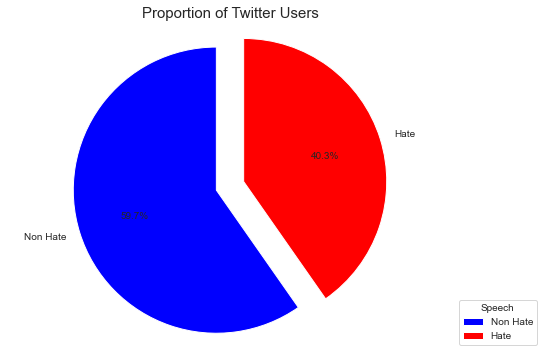

In [10]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 40.3% of twitter users might Hate. So the baseline model could be to predict that 40.3% of the users will Hate. Given 40.3% is a small number, we need to ensure that the chosen model does predict with great accuracy this 40.3% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [11]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent


labelled_data = labelled_data.drop('id', axis=1)
labelled_data = labelled_data.rename(columns={'index':'id'})

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')

The longest for labelled tweet is: 339
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 304
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

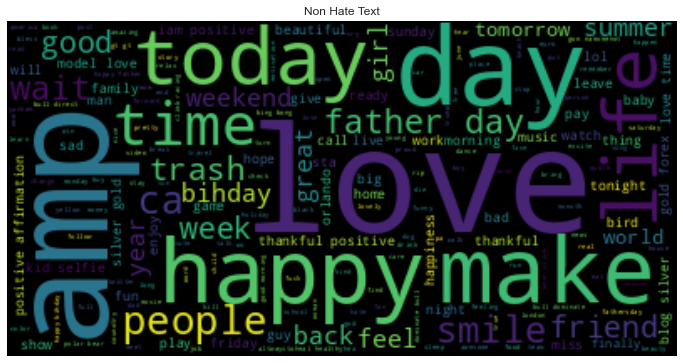

In [12]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Non Hate Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

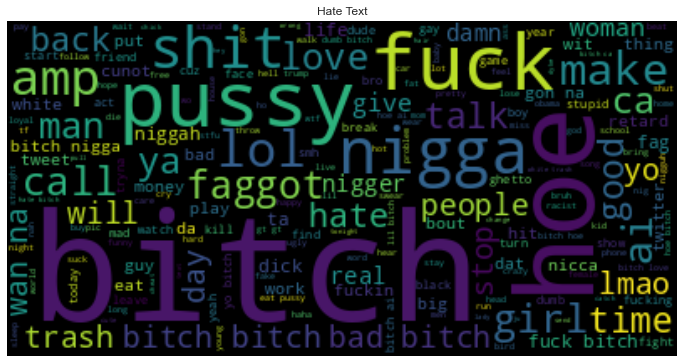

In [13]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [14]:
# We will encode text data using TF-IDF
def transform(data_cleaned, unlabelled_cleaned):
    tfVectorizer.fit(data_cleaned.cleaned_text)
    train_tfidf_feat = tfVectorizer.transform(data_cleaned.cleaned_text).toarray()
    unlabelled_tfidf_feat = tfVectorizer.transform(unlabelled_cleaned.cleaned_text).toarray()
    train_tfidf = pd.DataFrame(train_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    unlabelled_tfidf = pd.DataFrame(unlabelled_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    return tfVectorizer, train_tfidf, unlabelled_tfidf

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

tfVectorizer, data_train_tfidf, unlabelled_tfidf = transform(data_cleaned, unlabelled_cleaned)

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [15]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['id', 'tweet'], axis=1)
    return data


data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_train_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 7min 59s, sys: 4.34 s, total: 8min 3s
Wall time: 8min 16s


In [16]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['label'], axis=1)
print(f"Number of columns of the data_cleaned: {data_cleaned.shape[1]}")
print(f"Number of columns of the unlabelled_cleaned: {unlabelled_cleaned.shape[1]}")
print()
X_train, X_test, y_train, y_test = train_test_split(data_cleaned.values, target_labelled_data.values,
                                                    test_size=0.2, random_state=43)

print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'],
                           yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

def roc_auc_curve(y_test, prob):
    plt.figure(figsize=(14, 8))
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def train(model, scaler, X_train, y_train, X_test):
    
    """Sklearn training interface
    """
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_prob = pipeline.predict_proba(X_test)[:, 1]
    train_prob = pipeline.predict_proba(X_train)[:, 1]
    return y_pred, test_prob, train_prob


tags = {"application":"Sentiment Hate Detector",
        "developer": "daniel",
        "train-data1-path": f"{os.path.join(config.DATAPATH, 'train.csv')}",
        "train-data2-path": f"{os.path.join(config.DATAPATH, 'HateSpeechData.csv')}"}

Number of columns of the data_cleaned: 1018
Number of columns of the unlabelled_cleaned: 1018

Train Size: 0.80%
Test Size: 0.20%
(45396, 1018) (45396,) (11349, 1018) (11349,) (3914, 1018)


In [17]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

def binary_predict(probs):
    """Function to convert LightGBM .predict output to binary (0, 1)"""
    y_pred=(probs > 0.5).astype("int")
    return y_pred

# Check for Missing Values

In [17]:
print(pd.isnull(data_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


In [18]:
print(pd.isnull(unlabelled_cleaned).sum().sort_values(ascending=False))

about              0
police             0
pig                0
pink               0
piss               0
                  ..
friendship         0
fronot             0
fuck               0
fuck bitch         0
uppercase_count    0
Length: 1018, dtype: int64


# Model Building & Evaluation

## MLflow for Model Tracking and Experiment

In [19]:
# !mlflow ui --backend-store-uri sql|ite:///mlflow.db

### Get the best Model to perform Pseudo-Labelling (Semi-Supervised Learning) on the unlabelled_data

## MultinomialNB & Parameter tuning

In [22]:
with mlflow.start_run():
    for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
        y_pred, test_prob, train_prob = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        
        with mlflow.start_run(experiment_id=experiment_id, run_name='multi-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"alpha":a,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{a}->{train_auc:.4f}")
        print(f"{a}->{test_auc:.4f}")
#     mlflow.end_run()

0.0001->0.9639
0.0001->0.9639
0.001->0.9638
0.001->0.9640
0.01->0.9638
0.01->0.9641
0.1->0.9637
0.1->0.9642
1->0.9639
1->0.9645
10->0.9648
10->0.9655


Train ROC AUC Naive Bayes Score: 0.9648
Test ROC AUC Naive Bayes Score: 0.9655
'%' of Misclassified class: 8.837783064587189


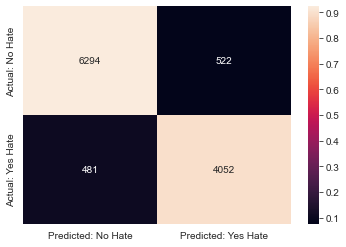

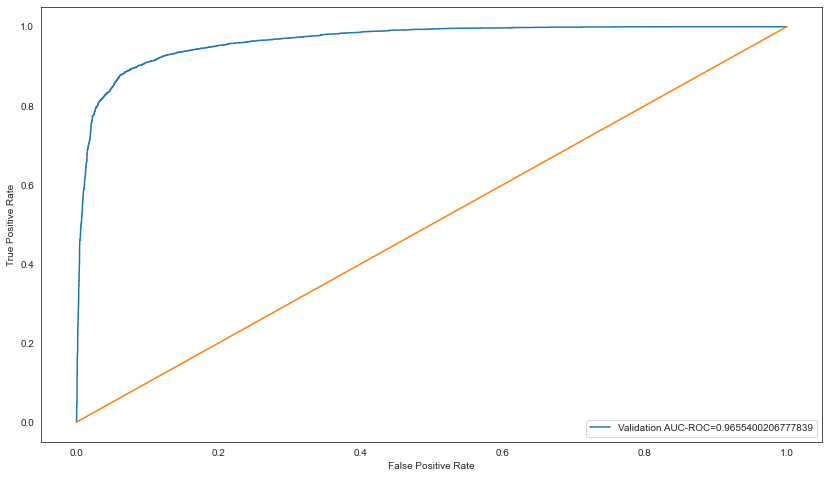

In [23]:
with mlflow.start_run(experiment_id=experiment_id, run_name='multi-final'):
    mlflow.set_tags(tags)
    
    a=10
    scaler=MinMaxScaler()
    y_pred, test_prob, train_prob = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_param("alpha",a)
    mlflow.log_param("scaler",scaler)
    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print(f"Train ROC AUC Naive Bayes Score: {train_auc:.4f}")
print(f"Test ROC AUC Naive Bayes Score: {test_auc:.4f}")
print(f"'%' of Misclassified class: {misclass}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Logistic Regression & Parameter tuning

In [24]:
with mlflow.start_run():
    
    for c in [0.00005, 0.0001, 0.001, 0.01, 0.1, 1]:
        y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=c), StandardScaler(),
                             X_train, y_train, X_test)
        
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"solver":'liblinear',
                               "C":c,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        
        print(f"{c}->{train_auc:.4f}")
        print(f"{c}->{test_auc:.4f}")

5e-05->0.9649
5e-05->0.9635
0.0001->0.9688
0.0001->0.9672
0.001->0.9783
0.001->0.9756
0.01->0.9823
0.01->0.9784
0.1->0.9833
0.1->0.9785
1->0.9834
1->0.9783


In [25]:
with mlflow.start_run():
    
    for m in [0.01, 0.1, 1]:
        print(f"Inverse of regularization strength C-> {m}")
        
        for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
            y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=m, tol=tol), StandardScaler(),
                                 X_train, y_train, X_test)
            train_auc = roc_auc_score(y_train, train_prob)
            test_auc = roc_auc_score(y_test, test_prob)
            with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-tuning', nested=True):
                mlflow.set_tags(tags)
                mlflow.log_params({"solver":'liblinear',"C":m, "tol":tol,
                                   "percent-misclassified":np.mean(y_pred != y_test)*100})
                mlflow.log_metrics({"train-auc-score":train_auc,
                                    "test-auc-score":test_auc})
            print(f"{tol}->{train_auc:.4f}")
            print(f"{tol}->{test_auc:.4f}")
        print()

Inverse of regularization strength C-> 0.01
1e-05->0.9823
1e-05->0.9784
0.0001->0.9823
0.0001->0.9784
0.001->0.9823
0.001->0.9784
0.01->0.9823
0.01->0.9784
0.1->0.9811
0.1->0.9775
1->0.9737
1->0.9709
10->0.5000
10->0.5000

Inverse of regularization strength C-> 0.1
1e-05->0.9833
1e-05->0.9785
0.0001->0.9833
0.0001->0.9785
0.001->0.9833
0.001->0.9785
0.01->0.9831
0.01->0.9784
0.1->0.9814
0.1->0.9776
1->0.9737
1->0.9708
10->0.5000
10->0.5000

Inverse of regularization strength C-> 1
1e-05->0.9834
1e-05->0.9783
0.0001->0.9834
0.0001->0.9783
0.001->0.9834
0.001->0.9783
0.01->0.9832
0.01->0.9784
0.1->0.9814
0.1->0.9776
1->0.9737
1->0.9708
10->0.5000
10->0.5000



In [26]:
for mClass in ["auto", "ovr"]:
    y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class=mClass),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    print(f"{mClass}->{train_auc:.4f}")
    print(f"{mClass}->{test_auc:.4f}")

auto->0.9833
auto->0.9785
ovr->0.9833
ovr->0.9785


Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785


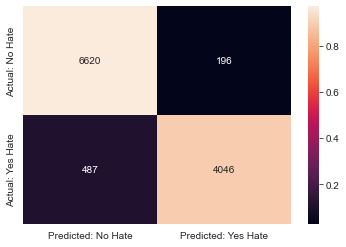

In [27]:
y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto'),
                                      StandardScaler(),
                                      X_train, y_train, X_test)

train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785
'%' of Misclassified class: 6.018151378976121


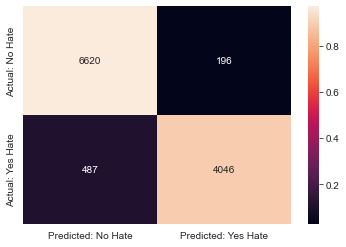

Train ROC AUC Logistic Regression Score: 0.9838
Test ROC AUC Logistic Regression Score: 0.9779
'%' of Misclassified class: 14.406555643669044


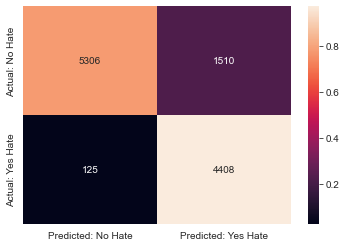

Train ROC AUC Logistic Regression Score: 0.9820
Test ROC AUC Logistic Regression Score: 0.9753
'%' of Misclassified class: 26.84818045642788


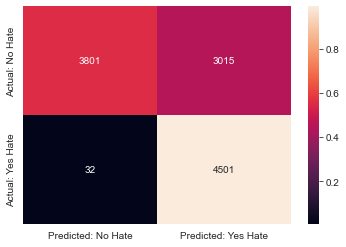

In [28]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    y_pred, test_prob, train_prob = train(LogisticRegression(solver='liblinear', C=0.1, tol=1e-05, multi_class='auto',
                                                             class_weight=weight),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
    print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

Train ROC AUC Logistic Regression Score: 0.9833
Test ROC AUC Logistic Regression Score: 0.9785


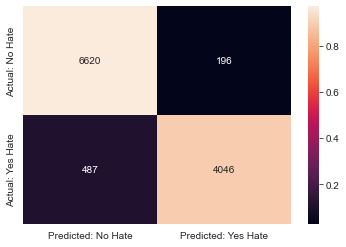

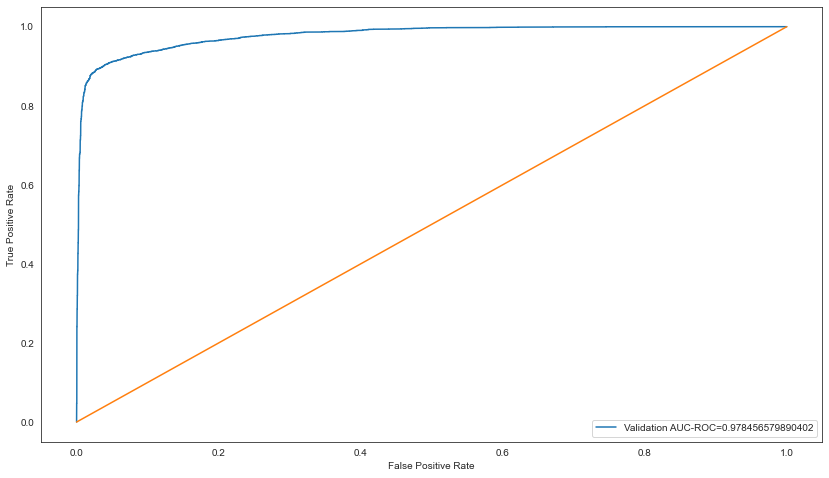

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [29]:
with mlflow.start_run(experiment_id=experiment_id, run_name='logreg-final'):
    mlflow.set_tags(tags)
    
    scaler=StandardScaler()
    solver='liblinear'
    C=0.1
    tol=1e-05
    multi_class='auto'
    class_weight={0:1,1:1}
    
    y_pred, test_prob, train_prob = train(LogisticRegression(solver=solver, C=C, tol=tol, multi_class=multi_class,
                                                             class_weight=class_weight),
                                          scaler,
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    mlflow.log_param("scaler", scaler)
    mlflow.log_param("solver", solver)
    mlflow.log_param("C", C)
    mlflow.log_param("tol", tol)
    mlflow.log_param("multi_class", multi_class)
    mlflow.log_param("class_weight", class_weight)
    mlflow.log_param("percent-misclassified", misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})

print(f"Train ROC AUC Logistic Regression Score: {train_auc:.4f}")
print(f"Test ROC AUC Logistic Regression Score: {test_auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

## Random Forest & Parameter tuning

In [30]:
with mlflow.start_run():
    
    random_state=42
    for n in [5, 10, 50, 200, 250, 300, 350]:
        y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n, random_state=random_state),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"random_state":random_state,
                             "n_estimators":n, "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{n}->{train_auc:.4f}")
        print(f"{n}->{test_auc:.4f}")

5->0.9991
5->0.9565
10->0.9999
10->0.9679
50->1.0000
50->0.9770
200->1.0000
200->0.9785
250->1.0000
250->0.9787
300->1.0000
300->0.9789
350->1.0000
350->0.9788


In [31]:
with mlflow.start_run():
    
    for m in [300, 350]:
        print(f"Number of estimators {m}")

        for c in ["gini", "entropy"]:
            y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=m, criterion=c, random_state=42),
                                                  StandardScaler(),
                                                  X_train, y_train, X_test)
            train_auc = roc_auc_score(y_train, train_prob)
            test_auc = roc_auc_score(y_test, test_prob)
            with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
                mlflow.set_tags(tags)
                mlflow.log_params({"random_state":random_state,
                                 "n_estimators":m, "criterion":c,
                                  "percent-misclassified":np.mean(y_pred != y_test)*100})
                mlflow.log_metrics({"train-auc-score":train_auc,
                                    "test-auc-score":test_auc})
                
            print(f"{c}->{train_auc:.4f}")
            print(f"{c}->{test_auc:.4f}")
        print()

Number of estimators 300
gini->1.0000
gini->0.9789
entropy->1.0000
entropy->0.9789

Number of estimators 350
gini->1.0000
gini->0.9788
entropy->1.0000
entropy->0.9790



In [32]:
with mlflow.start_run():
    
    n_estimators=350
    for depth in [1, 2, 3, 4, 5]:
        y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', 
                                                                     max_depth=depth),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_prob)
        test_auc = roc_auc_score(y_test, test_prob)
        with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-tuning', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"random_state": random_state,
                               "n_estimators": n_estimators,
                               "criterion":'entropy',
                               "depth":depth,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{depth}->{train_auc:.4f}")
        print(f"{depth}->{test_auc:.4f}")

1->0.9327
1->0.9299
2->0.9297
2->0.9265
3->0.9372
3->0.9343
4->0.9401
4->0.9371
5->0.9399
5->0.9371


Train ROC AUC Random Forest Classifier Score: 1.0000
Test ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.846418186624373


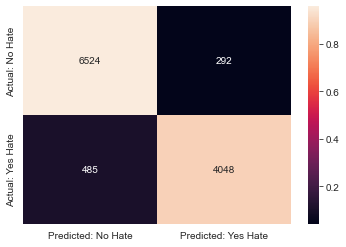

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [33]:
y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=300, criterion='entropy',
                                                             max_depth=None, class_weight={0:1,1:100}, random_state=42),
                                      StandardScaler(),
                                      X_train, y_train, X_test)

train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
print(f"Train ROC AUC Random Forest Classifier Score: {train_auc:.4f}")
print(f"Test ROC AUC Random Forest Classifier Score: {test_auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

Train ROC AUC Random Forest Classifier Score: 1.0000
Test ROC AUC Random Forest Classifier Score: 0.9790
'%' of Misclassified class: 6.546832320028197


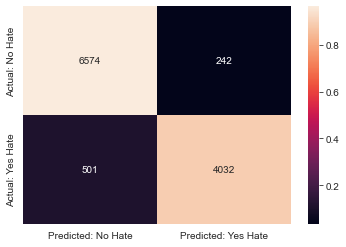

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,1
7,0,0
8,0,0
9,1,1


In [34]:
with mlflow.start_run(experiment_id=experiment_id, run_name='randfort-final'):
    mlflow.set_tags(tags)
    
    scaler=StandardScaler()
    n_estimators=350
    criterion='entropy'
    max_depth=None
    random_state=42
    
    y_pred, test_prob, train_prob = train(RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                                                 max_depth=max_depth, random_state=random_state),
                                          scaler,
                                          X_train, y_train, X_test)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    mlflow.log_param("scaler", scaler)
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("criterion", criterion)
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("random_state", random_state)
    mlflow.log_param("percent-misclassified", misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})

# auc = roc_auc_score(y_test, pred)
print(f"Train ROC AUC Random Forest Classifier Score: {train_auc:.4f}")
print(f"Test ROC AUC Random Forest Classifier Score: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [35]:
with mlflow.start_run():
    
    objective= 'binary'
    for n in [25, 50, 100, 150, 200, 250, 300, 350, 400]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n, objective=objective),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        misclass = np.mean(y_pred != y_test)*100
        with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,
                              "n_estimators":n, "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{n}->{train_auc:.5f}")
        print(f"{n}->{test_auc:.5f}")

25->0.97222
25->0.97054
50->0.98096
50->0.97735
100->0.98811
100->0.98116
150->0.99119
150->0.98207
200->0.99302
200->0.98258
250->0.99444
250->0.98282
300->0.99554
300->0.98281
350->0.99646
350->0.98285
400->0.99717
400->0.98278


In [36]:
with mlflow.start_run():
    
    n_estimators=400
    objective='binary'
    for alpha in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators,
                                                                 objective=objective,
                                                                 reg_alpha=alpha),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn', nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,
                               "n_estimators":n_estimators,"reg-alpha":alpha,
                               "percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{alpha}->{train_auc:.4f}")
        print(f"{alpha}->{test_auc:.4f}")

0.001->0.9971
0.001->0.9829
0.01->0.9971
0.01->0.9829
0.1->0.9971
0.1->0.9831
1->0.9963
1->0.9827
1.5->0.9958
1.5->0.9822
2->0.9954
2->0.9826
2.5->0.9950
2.5->0.9821


In [37]:
with mlflow.start_run():
    
    n_estimators=400
    objective='binary'
    alpha=0.1

    for lr in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
        y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                                 reg_alpha=alpha, learning_rate=lr),
                                              StandardScaler(),
                                              X_train, y_train, X_test)
        train_auc = roc_auc_score(y_train, train_pred)
        test_auc = roc_auc_score(y_test, test_pred)
        with mlflow.start_run(nested=True):
            mlflow.set_tags(tags)
            mlflow.log_params({"objective":objective,"n_estimators":n_estimators,"reg-alpha":alpha,
                             "learning-rate":lr,"percent-misclassified":np.mean(y_pred != y_test)*100})
            mlflow.log_metrics({"train-auc-score":train_auc,
                                "test-auc-score":test_auc})
        print(f"{lr}->{train_auc:.4f}")
        print(f"{lr}->{test_auc:.4f}")

0.001->0.9600
0.001->0.9594
0.01->0.9784
0.01->0.9755
0.1->0.9971
0.1->0.9831
1->0.7194
1->0.7094
1.5->0.5148
1.5->0.5165
2->0.6659
2->0.6635
2.5->0.5682
2.5->0.5717


ROC AUC LGBM Classifier Score: 0.9831


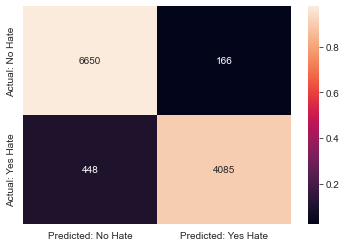

In [38]:
y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1, objective='binary'),
                                      StandardScaler(),
                                      X_train, y_train, X_test)
auc = roc_auc_score(y_test, test_pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

ROC AUC LGBM Classifier Score: 0.9831
'%' of Misclassified class: 5.410168296766235


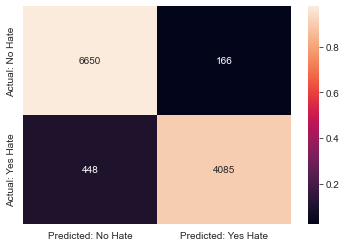

ROC AUC LGBM Classifier Score: 0.9829
'%' of Misclassified class: 9.718917966340648


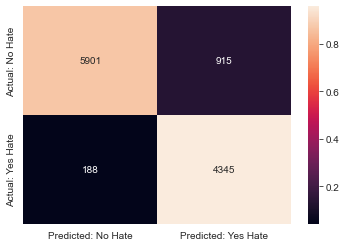

ROC AUC LGBM Classifier Score: 0.9797
'%' of Misclassified class: 17.29667812142039


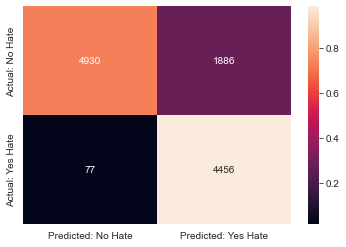

In [39]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, 
                                                             learning_rate=0.1, objective='binary',
                                                             class_weight=weight),
                                          StandardScaler(),
                                          X_train, y_train, X_test)
    auc = roc_auc_score(y_test, test_pred)
    print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
    print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC LGBM Classifier Score: 0.9831
'%' of Misclassified class: 5.410168296766235


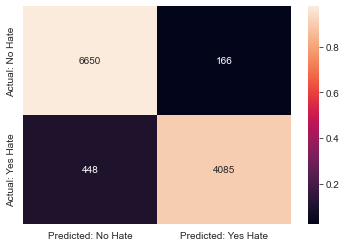

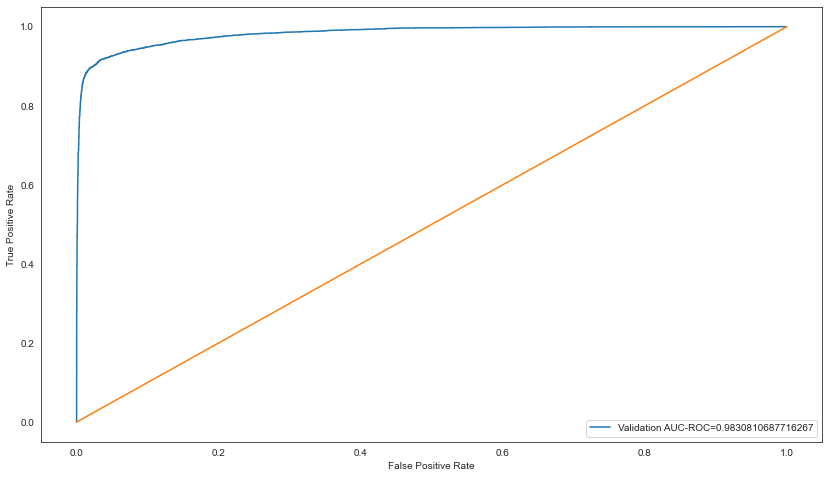

In [40]:
y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1, 
                                                         objective='binary',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler(),
                                      X_train, y_train, X_test)
auc = roc_auc_score(y_test, test_pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

## XGBoost Classifier & Parameter tuning

In [41]:
# trainD = xgb.DMatrix(X_train, label=y_train)
# validD = xgb.DMatrix(X_test, label=y_test)

In [42]:
# def objective(params):
    
#     with mlflow.start_run():
#         mlflow.set_tag("developer", "daniel")
#         mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
#         mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         xgb_model = xgb.train(
#             params=params,
#             dtrain=trainD,
#             num_boost_round=500,
#             evals= [(trainD, 'train'), (validD, 'val')],
#             early_stopping_rounds=50)
        
#         test_pred = xgb_model.predict(validD)
#         train_pred = xgb_model.predict(trainD)
        
#         train_pred = binary_predict(train_pred)
#         test_pred = binary_predict(test_pred)

#         train_auc = roc_auc_score(y_train, train_pred)
#         test_auc = roc_auc_score(y_test, test_pred)
# #         auc = roc_auc_score(y_test, y_pred)
#         misclass = np.mean(test_pred != y_test)*100
        
#         mlflow.log_param("percent-misclassified",misclass)
#         mlflow.log_metrics({"train-auc-score":train_auc})
#         mlflow.log_metrics({"test-auc-score":test_auc})
    
#     return {'loss':test_auc, 'status':STATUS_OK}

# search_space = {
#     "max_depth":scope.int(hp.quniform("max_depth", 4, 100, 1)),
# #     "learning_rate":hp.loguniform("learning_rate", -15, -1), # exponential(-7) and exponential(0)
#     'eta': hp.loguniform("eta", -9, 0),
#     "reg_alpha":hp.loguniform("reg_alpha", -15, -2),
#     "reg_lambda":hp.loguniform("reg_lambda", -15, -2),
#     "min_child_weight":hp.loguniform("min_child_weight", -9, -2),
#     "objective":"binary:logistic",
# #     "eval_metric":"auc",
#     "seed":43
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=5,
#     trials=Trials()
# )

In [43]:
# for n in [200, 250, 300, 350]:
#     pred, y_pred = train(xgb.XGBClassifier(n_estimators=n, eval_metric="auc", 
#                                        objective='binary:logistic'),
#                          StandardScaler(),
#                          X_train, y_train, X_test)
#     auc = roc_auc_score(y_test, pred)
#     print(f"{n}->{auc:.4f}")

In [44]:
# for lr in [0.0001, 0.001, 0.1, 1, 1.5]:
#     pred, y_pred = train(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
#                                        objective='binary:logistic', learning_rate=lr),
#                          StandardScaler(),
#                          X_train, y_train, X_test)
#     auc = roc_auc_score(y_test, pred)
#     print(f"{lr}->{auc:.4f}")

In [45]:
# pred, y_pred = train(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
#                                     objective='binary:logistic'),
#                      StandardScaler(),
#                      X_train, y_train, X_test)
# auc = roc_auc_score(y_test, pred)
# print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# roc_auc_curve(y_test, pred)
# plt.show()

The LGBM Model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [38]:
def cross_validation_score(ml_model, scaler, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        pipeline = make_pipeline(scaler, model)
        pipeline.fit(xtrain, ytrain)
        y_pred = pipeline.predict(xval)
        pred_probs = pipeline.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Multinomial NB

In [39]:
y=target_labelled_data
nb_cv_score = cross_validation_score(MultinomialNB(alpha=10), MinMaxScaler())


1 of KFold 5
ROC AUC Score: 0.9619, Recall Score: 0.8841, Precision Score: 0.8821

2 of KFold 5
ROC AUC Score: 0.9633, Recall Score: 0.8841, Precision Score: 0.8921

3 of KFold 5
ROC AUC Score: 0.9652, Recall Score: 0.8948, Precision Score: 0.8870

4 of KFold 5
ROC AUC Score: 0.9660, Recall Score: 0.9025, Precision Score: 0.8889

5 of KFold 5
ROC AUC Score: 0.9608, Recall Score: 0.8769, Precision Score: 0.8777


## Logistic Regression

In [59]:
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear', 
                                                         C=0.1, tol=1e-05, 
                                                         multi_class='auto',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9773, Recall Score: 0.8845, Precision Score: 0.9513

2 of KFold 5
ROC AUC Score: 0.9778, Recall Score: 0.8928, Precision Score: 0.9524

3 of KFold 5
ROC AUC Score: 0.9794, Recall Score: 0.8983, Precision Score: 0.9538

4 of KFold 5
ROC AUC Score: 0.9793, Recall Score: 0.8959, Precision Score: 0.9504

5 of KFold 5
ROC AUC Score: 0.9760, Recall Score: 0.8863, Precision Score: 0.9532


## RandomForestClassifier

In [60]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                                            max_depth=None, random_state=42),
                                     StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9772, Recall Score: 0.8882, Precision Score: 0.9471

2 of KFold 5
ROC AUC Score: 0.9795, Recall Score: 0.8909, Precision Score: 0.9485

3 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8983, Precision Score: 0.9520

4 of KFold 5
ROC AUC Score: 0.9803, Recall Score: 0.8953, Precision Score: 0.9508

5 of KFold 5
ROC AUC Score: 0.9768, Recall Score: 0.8885, Precision Score: 0.9504


## LGBM Model

In [61]:
lgm_cv_score = cross_validation_score(lgb.LGBMClassifier(n_estimators=400, 
                                                     reg_alpha=0.1,
                                                     learning_rate=0.1,
                                                     objective='binary',
                                                     class_weight={0:1,1:1}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9820, Recall Score: 0.8926, Precision Score: 0.9607

2 of KFold 5
ROC AUC Score: 0.9825, Recall Score: 0.8983, Precision Score: 0.9571

3 of KFold 5
ROC AUC Score: 0.9850, Recall Score: 0.9064, Precision Score: 0.9669

4 of KFold 5
ROC AUC Score: 0.9842, Recall Score: 0.9031, Precision Score: 0.9638

5 of KFold 5
ROC AUC Score: 0.9820, Recall Score: 0.8948, Precision Score: 0.9674


## XGBClassifier

In [62]:
xgb_cv_score = cross_validation_score(xgb.XGBClassifier(n_estimators=350, eval_metric="auc", 
                                                    objective='binary:logistic'),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9811, Recall Score: 0.8917, Precision Score: 0.9609

2 of KFold 5
ROC AUC Score: 0.9821, Recall Score: 0.8987, Precision Score: 0.9618

3 of KFold 5
ROC AUC Score: 0.9842, Recall Score: 0.9027, Precision Score: 0.9661

4 of KFold 5
ROC AUC Score: 0.9841, Recall Score: 0.9018, Precision Score: 0.9647

5 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.8944, Precision Score: 0.9658


# Comparison of Model Fold wise

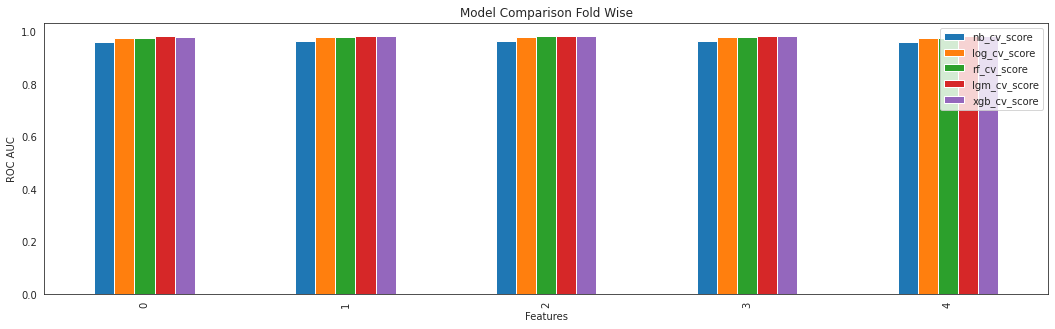

In [63]:
compare_score = pd.DataFrame({'nb_cv_score':nb_cv_score,
                              'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'lgm_cv_score':lgm_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['nb_cv_score','log_cv_score','rf_cv_score',
                        'lgm_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `LGBM Model` has the best performance across 5-fold. Therefore, we will work on improving it.**

In [49]:
lgb_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                           objective='binary',
                                                           class_weight={0:1,1:1}))

lgb_model.fit(X_train, y_train)

step_factor = 0.02
threshold_value = 0.1
roc_score = 0
proba = lgb_model.predict_proba(X_test)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.8939630988556532
Threshold: 0.12000000000000001->0.9066110067641676
Threshold: 0.14->0.9141956928533477
Threshold: 0.16->0.919325863076096
Threshold: 0.18->0.9236121629956221
Threshold: 0.19999999999999998->0.9269817698380888
Threshold: 0.21999999999999997->0.9282952499355276
Threshold: 0.23999999999999996->0.9301618432745157
Threshold: 0.25999999999999995->0.932432166071656
Threshold: 0.27999999999999997->0.9345557752537728
Threshold: 0.3->0.9361294753963889
Threshold: 0.32->0.9372625006602597
Threshold: 0.34->0.9388736802571439
Threshold: 0.36000000000000004->0.9393839737076772
Threshold: 0.38000000000000006->0.9390118493333707
Threshold: 0.4000000000000001->0.9391558927800201
Threshold: 0.4200000000000001->0.9387848364730631
Threshold: 0.4400000000000001->0.9379361598667674
Threshold: 0.46000000000000013->0.9377492966291019
Threshold: 0.48000000000000015->0.9372690061613893
Threshold: 0.5000000000000001->0.9374494609949572
Threshold: 0.5200000000000001->0.937630449

In [50]:
cross_validation_score(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                      objective='binary',
                                      class_weight={0:1,1:1}),
                       StandardScaler(), thres=0.36)


1 of KFold 5
ROC AUC Score: 0.9815, Recall Score: 0.9084, Precision Score: 0.9390

2 of KFold 5
ROC AUC Score: 0.9828, Recall Score: 0.9147, Precision Score: 0.9370

3 of KFold 5
ROC AUC Score: 0.9849, Recall Score: 0.9217, Precision Score: 0.9446

4 of KFold 5
ROC AUC Score: 0.9840, Recall Score: 0.9171, Precision Score: 0.9385

5 of KFold 5
ROC AUC Score: 0.9813, Recall Score: 0.9079, Precision Score: 0.9473


[0.9815020724593283,
 0.9827641896688544,
 0.9848852540326365,
 0.9839785187478168,
 0.9813013656720792]

There is no improvement in the recall score. There was no improvement in the recall till after we gathered more data which improved the roc across all model.

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

**My approach to Semi-Supervised Learning**

1. Select the best model after Supervised learning which is the LGBM Model
2. Try to improve the model with different SMOTE techniques
3. Select the SMOTE with low '%' of Misclassification & high ROC
4. Train model with SMOTE training data if the '%' of Misclassification is lower than the original training data
5. Perform Pseudo Labelling on with the best model
6. Select a better confidence/probability value via the graph with the new training data.
7. Training the model with the new training data based on the confidence.
8. Do step 2,3,4 and 5.
9. Store model for deployment.

# Addressing Imbalanced Class with SMOTE on LGBMClassifier for Semi-supervised Learning

In [18]:
print(X_train.shape)
print(y_train.shape)
print()
print(Counter(y_train))

(45396, 1018)
(45396,)

Counter({0: 27067, 1: 18329})


In [18]:
X_train_ada, y_train_ada = ADASYN(random_state = 154).fit_resample(X_train, y_train)
print(X_train_ada.shape)
print(y_train_ada.shape)
print(Counter(y_train_ada))

(54451, 1018)
(54451,)
Counter({1: 27384, 0: 27067})


'%' of Misclassified class: 5.30443210855582


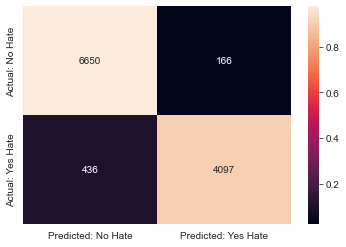

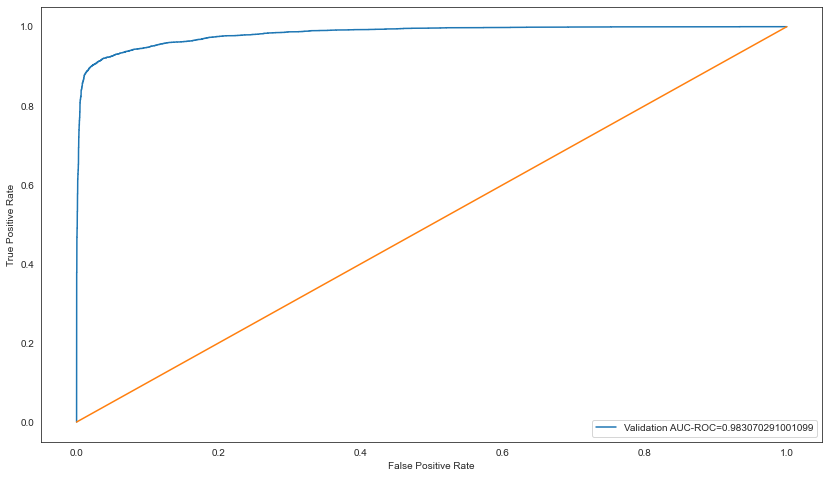

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [20]:
with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-ada'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_ada, y_train_ada, X_test)
    
    train_auc = roc_auc_score(y_train_ada, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"objective":objective,"SMOTE":'ada',
                     "n_estimators":n_estimators,"reg-alpha":alpha,"learning_rate":lr,
                     "class_weight":balance,
                     "percent-misclassified":misclass})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [19]:
X_train_bls, y_train_bls = BorderlineSMOTE(random_state = 154).fit_resample(X_train, y_train)
print(X_train_bls.shape)
print(y_train_bls.shape)
print(Counter(y_train_bls))

(54134, 1018)
(54134,)
Counter({0: 27067, 1: 27067})


(54134, 1018)
(54134,)
Counter({0: 27067, 1: 27067})
'%' of Misclassified class: 5.392545598731166


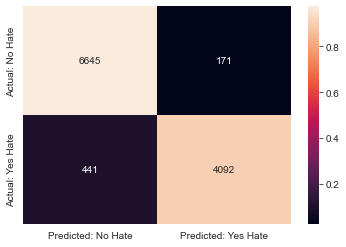

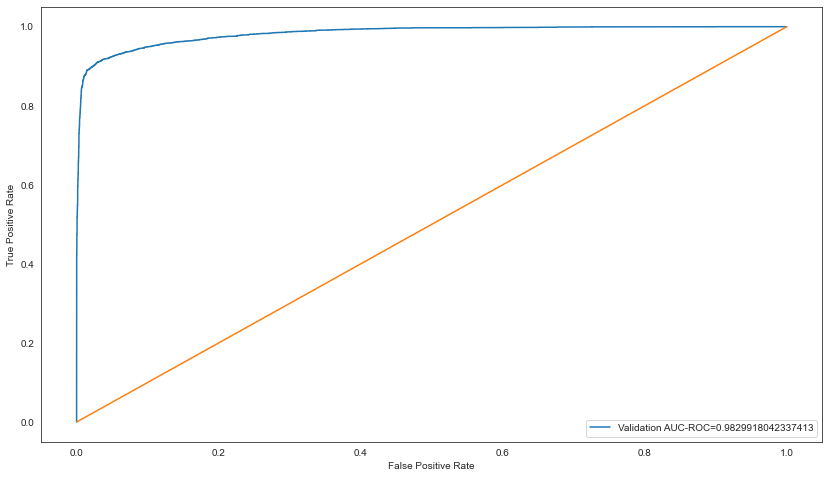

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [21]:
with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-bls'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_bls, y_train_bls, X_test)
    
    train_auc = roc_auc_score(y_train_bls, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"objective":objective,"SMOTE":'bls',"n_estimators":n_estimators,
                       "reg-alpha":alpha,"learning_rate":lr,"class_weight":balance,
                       "percent-misclassified":np.mean(y_pred != y_test)*100})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [20]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_sm, y_train_sm = smote_pipe.fit_resample(X_train, y_train)
print(X_train_sm.shape)
print(y_train_sm.shape)
print()
print(Counter(y_train_sm))

(45711, 1018)
(45711,)

Counter({0: 24058, 1: 21653})


'%' of Misclassified class: 5.322054806590889


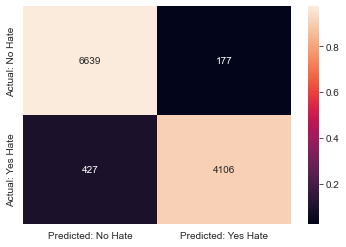

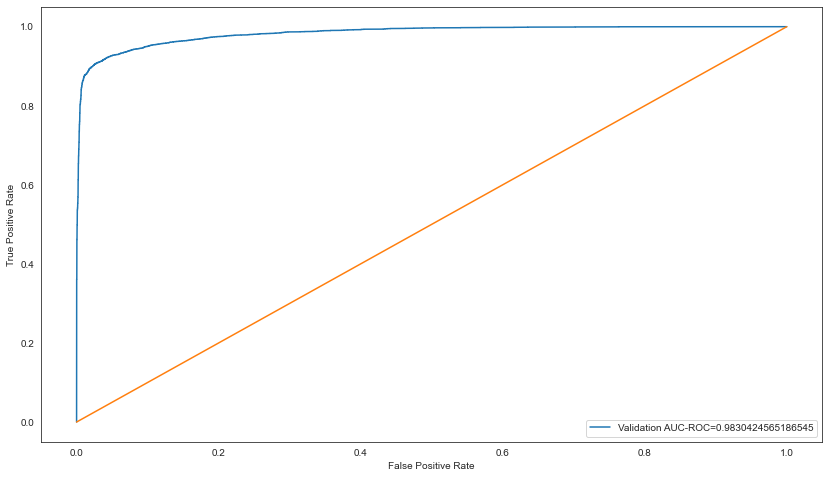

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [23]:
with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-tuning-sklearn-sm'):
    mlflow.set_tags(tags)
    
    n_estimators=400
    objective='binary'
    alpha=0.1
    lr=0.1
    balance={0:1,1:1}
    
    y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=n_estimators, objective=objective, 
                                                             reg_alpha=alpha, learning_rate=lr, class_weight=balance),
                                          StandardScaler(),
                                          X_train_sm, y_train_sm, X_test)
    
    train_auc = roc_auc_score(y_train_sm, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_param("objective", objective)
    mlflow.log_param("SMOTE", 'sm')
    mlflow.log_param("n_estimators",n_estimators)
    mlflow.log_params({"reg-alpha":alpha})
    mlflow.log_params({"learning_rate":lr})
    mlflow.log_params({"class_weight":balance})
    mlflow.log_params({"percent-misclassified":np.mean(y_pred != y_test)*100})
    mlflow.log_metrics({"train-auc-score":train_auc})
    mlflow.log_metrics({"test-auc-score":test_auc})
    
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

**We will train the model for psuedo-model with the BorderlineSmote data, because of the low '%' of Misclassified class though the roc score came down a bit. For imbalance problem accuracy/roc score is not essential as compared to the '%' of Misclassified class.**

# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

ROC AUC LGBClassifer Score before Semi-Supervised Learning: 0.9830
'%' of Misclassified class: 5.392545598731166


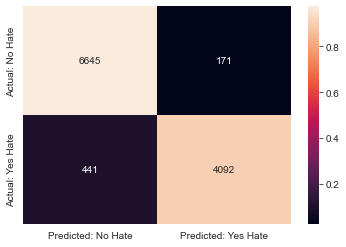

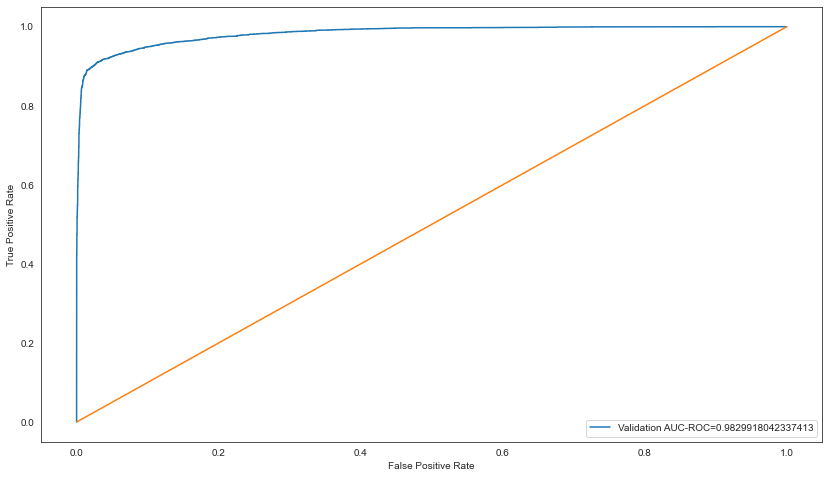

In [21]:
semi_sup_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                                    objective='binary',
                                                                    class_weight={0:1,1:1}))
semi_sup_model.fit(X_train_bls, y_train_bls)
pred = semi_sup_model.predict_proba(X_test)[:, 1]
y_pred = semi_sup_model.predict(X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBClassifer Score before Semi-Supervised Learning: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

In [22]:
unlabelled_cleaned = unlabelled_cleaned.values
probs = semi_sup_model.predict_proba(unlabelled_cleaned)
preds = semi_sup_model.predict(unlabelled_cleaned)

df_pseudo = pd.DataFrame(probs, columns = ['C1Prob', 'C2Prob']) 
df_pseudo['lab']=preds
df_pseudo['max']=df_pseudo[["C1Prob", "C2Prob"]].max(axis=1)

In [23]:
# Ensure the datatype are all in numpy arrays
print(type(X_train), type(y_train), type(X_test), type(y_test), type(unlabelled_cleaned))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [24]:
print(f"Unlabelled length -> {unlabelled_cleaned.shape[0]}")
print(f"Pseudo length -> {df_pseudo.shape[0]}")
df_pseudo.head()

Unlabelled length -> 3914
Pseudo length -> 3914


,C1Prob,C2Prob,lab,max
0,0.733367,0.266633,0,0.733367
1,0.634063,0.365937,0,0.634063
2,0.950501,0.049499,0,0.950501
3,0.649639,0.350361,0,0.649639
4,0.931930,0.068070,0,0.931930


## Plotting the Confidence

The below graph gives the distribution of confidence as expressed by the probability of the class which is most probable.

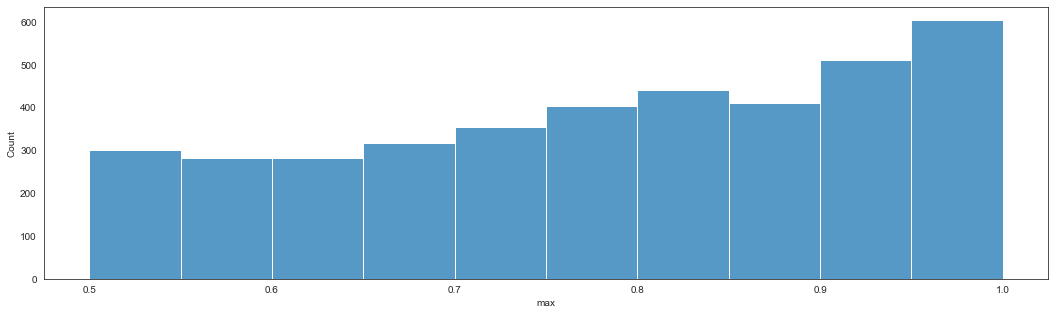

In [28]:
sns.histplot(data = df_pseudo, x = 'max', bins=10)
plt.show()

In [29]:
def check_score(model, scaler, X_train, y_train, X_test, y_test):
    
    """Function to confirm the confidence that best fit the data
    """
    with mlflow.start_run(experiment_id=experiment_id):
        mlflow.set_tag("developer", "daniel")
        mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
        mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
        
        print(f"Old Train Data shape: {X_train.shape[0]} \nOld Train label shape: {y_train.shape[0]}\n")
        nc=np.arange(.5,1,0.001)
        # print(len(nc))
        auc_scores=np.empty(len(nc))
        i=0
        for k in np.nditer(nc):
            conf_ind=df_pseudo["max"]>k
            X_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
            y_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])
            test_model = make_pipeline(scaler, model)
            test_model.fit(X_new, y_new)
            pred = test_model.predict_proba(X_test)[:, 1]
            y_pred = test_model.predict(X_test)
            print(f"Iteration-> {i}")
            print(f"New Train Data shape: {X_new.shape[0]} \nNew Train label shape: {y_new.shape[0]}\n")
            # print(f"New Train instances remaining-> {len(X_new)}")
            misclass = np.mean(y_pred != y_test)*100
            print("'%' of Misclassified class:", misclass)
            auc_scores[i] = roc_auc_score(y_test, pred)
            print(f"{k}->{roc_auc_score(y_test, pred)}")
            print()
            with mlflow.start_run(experiment_id=experiment_id, nested=True):
                mlflow.set_tag("model", "lgb-tuning-sklearn-semi-supervised-learn")
                mlflow.log_params({"Iteration":i})
                mlflow.log_params({"New Train Data shape": X_new.shape[0]})
                mlflow.log_params({"New Train label shape": y_new.shape[0]})
                mlflow.log_params({"percent-misclassified":misclass})
                mlflow.log_params({"k":k})
                mlflow.log_metrics({"test-auc-score":roc_auc_score(y_test, pred)})
            i += 1
    return auc_scores, nc

def conf_and_roc_plot(auc, nc):
    compare=pd.Series(auc, index=nc)
    compare.plot()
    plt.title('Confidence vs ROC')
    plt.xlabel('Confidence')
    plt.ylabel('ROC Score')
    plt.show()

In [30]:
auc_scores, nc = check_score(lgb.LGBMClassifier(n_estimators=400, 
                                                reg_alpha=0.1,
                                                learning_rate=0.1,
                                                objective='binary',
                                                class_weight={0:1,1:1}),
                             StandardScaler(),
                             X_train, y_train, X_test, y_test)

Old Train Data shape: 45396 
Old Train label shape: 45396

Iteration-> 0
New Train Data shape: 49310 
New Train label shape: 49310

'%' of Misclassified class: 5.313243457573354
0.5->0.9824379303987762

Iteration-> 1
New Train Data shape: 49303 
New Train label shape: 49303

'%' of Misclassified class: 5.357300202661027
0.501->0.9825915379030563

Iteration-> 2
New Train Data shape: 49296 
New Train label shape: 49296

'%' of Misclassified class: 5.41897964578377
0.502->0.9826923246220465

Iteration-> 3
New Train Data shape: 49292 
New Train label shape: 49292

'%' of Misclassified class: 5.401356947748701
0.503->0.9827069539081685

Iteration-> 4
New Train Data shape: 49283 
New Train label shape: 49283

'%' of Misclassified class: 5.51590448497665
0.504->0.9824955736699778

Iteration-> 5
New Train Data shape: 49273 
New Train label shape: 49273

'%' of Misclassified class: 5.454225041853908
0.505->0.9825748372135896

Iteration-> 6
New Train Data shape: 49265 
New Train label shape: 492

Iteration-> 56
New Train Data shape: 48978 
New Train label shape: 48978

'%' of Misclassified class: 5.383734249713632
0.556->0.9828940113398976

Iteration-> 57
New Train Data shape: 48974 
New Train label shape: 48974

'%' of Misclassified class: 5.410168296766235
0.557->0.9825726687132131

Iteration-> 58
New Train Data shape: 48970 
New Train label shape: 48970

'%' of Misclassified class: 5.410168296766235
0.558->0.9827841298655969

Iteration-> 59
New Train Data shape: 48963 
New Train label shape: 48963

'%' of Misclassified class: 5.436602343818839
0.559->0.98259137607467

Iteration-> 60
New Train Data shape: 48958 
New Train label shape: 48958

'%' of Misclassified class: 5.366111551678562
0.56->0.9828448316932997

Iteration-> 61
New Train Data shape: 48949 
New Train label shape: 48949

'%' of Misclassified class: 5.471847739888977
0.561->0.9828170781250486

Iteration-> 62
New Train Data shape: 48947 
New Train label shape: 48947

'%' of Misclassified class: 5.401356947748701
0

Iteration-> 108
New Train Data shape: 48686 
New Train label shape: 48686

'%' of Misclassified class: 5.339677504625958
0.6080000000000001->0.9828692677796317

Iteration-> 109
New Train Data shape: 48681 
New Train label shape: 48681

'%' of Misclassified class: 5.445413692836373
0.6090000000000001->0.9825614378232036

Iteration-> 110
New Train Data shape: 48675 
New Train label shape: 48675

'%' of Misclassified class: 5.427790994801304
0.6100000000000001->0.9827495309566052

Iteration-> 111
New Train Data shape: 48669 
New Train label shape: 48669

'%' of Misclassified class: 5.5423385320292535
0.6110000000000001->0.9823486658608908

Iteration-> 112
New Train Data shape: 48661 
New Train label shape: 48661

'%' of Misclassified class: 5.480659088906512
0.6120000000000001->0.9824542912486316

Iteration-> 113
New Train Data shape: 48656 
New Train label shape: 48656

'%' of Misclassified class: 5.410168296766235
0.6130000000000001->0.9825555310871036

Iteration-> 114
New Train Data sh

Iteration-> 159
New Train Data shape: 48387 
New Train label shape: 48387

'%' of Misclassified class: 5.410168296766235
0.6590000000000001->0.9826360407092898

Iteration-> 160
New Train Data shape: 48382 
New Train label shape: 48382

'%' of Misclassified class: 5.233941316415543
0.6600000000000001->0.9827186379176596

Iteration-> 161
New Train Data shape: 48381 
New Train label shape: 48381

'%' of Misclassified class: 5.410168296766235
0.6610000000000001->0.9826349726419403

Iteration-> 162
New Train Data shape: 48372 
New Train label shape: 48372

'%' of Misclassified class: 5.41897964578377
0.6620000000000001->0.9827052061615964

Iteration-> 163
New Train Data shape: 48366 
New Train label shape: 48366

'%' of Misclassified class: 5.3484888536434925
0.6630000000000001->0.9825384258266712

Iteration-> 164
New Train Data shape: 48360 
New Train label shape: 48360

'%' of Misclassified class: 5.392545598731166
0.6640000000000001->0.9824923371022517

Iteration-> 165
New Train Data sha

Iteration-> 210
New Train Data shape: 48042 
New Train label shape: 48042

'%' of Misclassified class: 5.4630363908714425
0.7100000000000002->0.9825356100127496

Iteration-> 211
New Train Data shape: 48030 
New Train label shape: 48030

'%' of Misclassified class: 5.295620759538285
0.7110000000000002->0.9827144303796158

Iteration-> 212
New Train Data shape: 48022 
New Train label shape: 48022

'%' of Misclassified class: 5.330866155608423
0.7120000000000002->0.9827103684871196

Iteration-> 213
New Train Data shape: 48013 
New Train label shape: 48013

'%' of Misclassified class: 5.2691867124856815
0.7130000000000002->0.9827069215424912

Iteration-> 214
New Train Data shape: 48006 
New Train label shape: 48006

'%' of Misclassified class: 5.225129967398009
0.7140000000000002->0.9826465271887225

Iteration-> 215
New Train Data shape: 47997 
New Train label shape: 47997

'%' of Misclassified class: 5.339677504625958
0.7150000000000002->0.9827044941166968

Iteration-> 216
New Train Data s

Iteration-> 261
New Train Data shape: 47689 
New Train label shape: 47689

'%' of Misclassified class: 5.322054806590889
0.7610000000000002->0.9828320148851044

Iteration-> 262
New Train Data shape: 47680 
New Train label shape: 47680

'%' of Misclassified class: 5.251564014450612
0.7620000000000002->0.9823862424121906

Iteration-> 263
New Train Data shape: 47670 
New Train label shape: 47670

'%' of Misclassified class: 5.322054806590889
0.7630000000000002->0.9826019596511343

Iteration-> 264
New Train Data shape: 47657 
New Train label shape: 47657

'%' of Misclassified class: 5.3484888536434925
0.7640000000000002->0.9824749890992398

Iteration-> 265
New Train Data shape: 47648 
New Train label shape: 47648

'%' of Misclassified class: 5.357300202661027
0.7650000000000002->0.982277056799951

Iteration-> 266
New Train Data shape: 47641 
New Train label shape: 47641

'%' of Misclassified class: 5.445413692836373
0.7660000000000002->0.9827482525123532

Iteration-> 267
New Train Data sha

Iteration-> 312
New Train Data shape: 47239 
New Train label shape: 47239

'%' of Misclassified class: 5.322054806590889
0.8120000000000003->0.9825947582879437

Iteration-> 313
New Train Data shape: 47231 
New Train label shape: 47231

'%' of Misclassified class: 5.3484888536434925
0.8130000000000003->0.9826861589605285

Iteration-> 314
New Train Data shape: 47220 
New Train label shape: 47220

'%' of Misclassified class: 5.339677504625958
0.8140000000000003->0.9826880847183255

Iteration-> 315
New Train Data shape: 47213 
New Train label shape: 47213

'%' of Misclassified class: 5.357300202661027
0.8150000000000003->0.9828478093356077

Iteration-> 316
New Train Data shape: 47209 
New Train label shape: 47209

'%' of Misclassified class: 5.330866155608423
0.8160000000000003->0.9826236770205762

Iteration-> 317
New Train Data shape: 47203 
New Train label shape: 47203

'%' of Misclassified class: 5.392545598731166
0.8170000000000003->0.9823605440644454

Iteration-> 318
New Train Data sh

Iteration-> 363
New Train Data shape: 46815 
New Train label shape: 46815

'%' of Misclassified class: 5.339677504625958
0.8630000000000003->0.982523019764295

Iteration-> 364
New Train Data shape: 46808 
New Train label shape: 46808

'%' of Misclassified class: 5.30443210855582
0.8640000000000003->0.9825727334445679

Iteration-> 365
New Train Data shape: 46795 
New Train label shape: 46795

'%' of Misclassified class: 5.401356947748701
0.8650000000000003->0.9828935744032545

Iteration-> 366
New Train Data shape: 46786 
New Train label shape: 46786

'%' of Misclassified class: 5.30443210855582
0.8660000000000003->0.9827321020394001

Iteration-> 367
New Train Data shape: 46768 
New Train label shape: 46768

'%' of Misclassified class: 5.277998061503216
0.8670000000000003->0.9826886511176776

Iteration-> 368
New Train Data shape: 46752 
New Train label shape: 46752

'%' of Misclassified class: 5.366111551678562
0.8680000000000003->0.9828069476680659

Iteration-> 369
New Train Data shape:

Iteration-> 414
New Train Data shape: 46385 
New Train label shape: 46385

'%' of Misclassified class: 5.339677504625958
0.9140000000000004->0.98257176247425

Iteration-> 415
New Train Data shape: 46379 
New Train label shape: 46379

'%' of Misclassified class: 5.3484888536434925
0.9150000000000004->0.9827894216538291

Iteration-> 416
New Train Data shape: 46372 
New Train label shape: 46372

'%' of Misclassified class: 5.383734249713632
0.9160000000000004->0.9827380896896933

Iteration-> 417
New Train Data shape: 46365 
New Train label shape: 46365

'%' of Misclassified class: 5.366111551678562
0.9170000000000004->0.9826424005648717

Iteration-> 418
New Train Data shape: 46357 
New Train label shape: 46357

'%' of Misclassified class: 5.383734249713632
0.9180000000000004->0.9825722479594088

Iteration-> 419
New Train Data shape: 46352 
New Train label shape: 46352

'%' of Misclassified class: 5.401356947748701
0.9190000000000004->0.9826908034352153

Iteration-> 420
New Train Data shap

Iteration-> 465
New Train Data shape: 45817 
New Train label shape: 45817

'%' of Misclassified class: 5.374922900696097
0.9650000000000004->0.9831344235905913

Iteration-> 466
New Train Data shape: 45810 
New Train label shape: 45810

'%' of Misclassified class: 5.357300202661027
0.9660000000000004->0.9828103136985011

Iteration-> 467
New Train Data shape: 45795 
New Train label shape: 45795

'%' of Misclassified class: 5.286809410520751
0.9670000000000004->0.9827328788156543

Iteration-> 468
New Train Data shape: 45780 
New Train label shape: 45780

'%' of Misclassified class: 5.383734249713632
0.9680000000000004->0.9827021314222566

Iteration-> 469
New Train Data shape: 45766 
New Train label shape: 45766

'%' of Misclassified class: 5.374922900696097
0.9690000000000004->0.9831566102623536

Iteration-> 470
New Train Data shape: 45755 
New Train label shape: 45755

'%' of Misclassified class: 5.295620759538285
0.9700000000000004->0.9828681026152503

Iteration-> 471
New Train Data sha

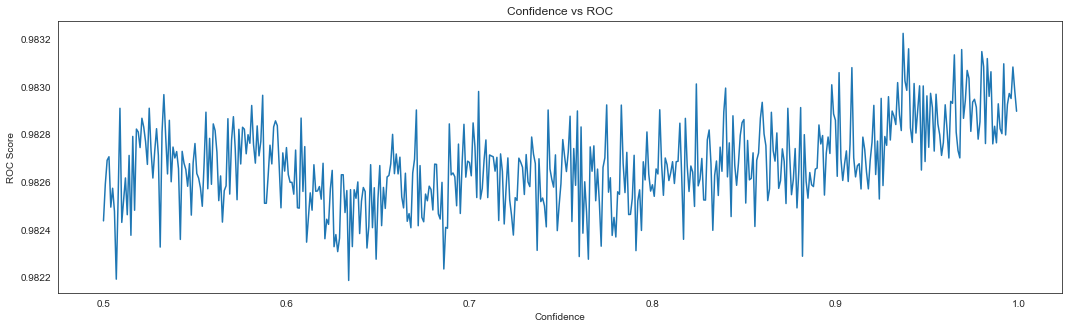

In [31]:
conf_and_roc_plot(auc_scores, nc)

We will consider probability/confidence at 0.85 begin to increase which is a good sign

**max -> ROC -> Misclassification**
1. 0.94 -> 0.9829 -> 5.3484
2. 0.996 -> 0.9827 -> 5.3132
3. 0.990 -> 0.9831 -> 5.3661
4. 0.976 -> 0.9830 -> 5.3308 -> Best
5. 0.985 -> 0.9827 -> 5.2956
6. 0.887 -> 0.9832 -> 5.3661

New Data ROC AUC LGBMClassifier Score semi-supervised: 0.9830
'%' of Misclassified class: 5.3484888536434925


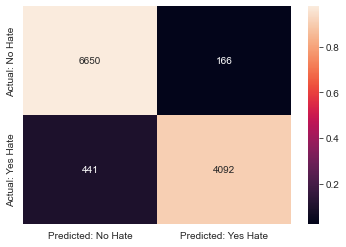

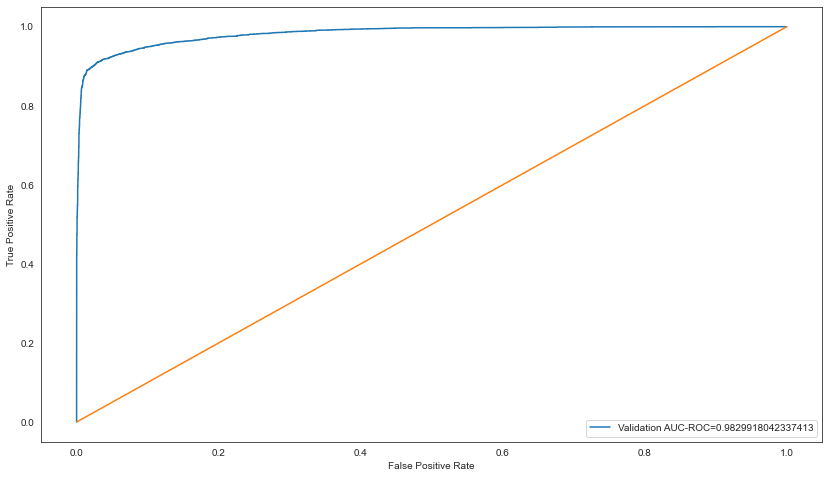

,Actual Label,Predicted_class
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


In [25]:
conf_ind=df_pseudo["max"]>0.979
X_train_new = np.append(X_train, unlabelled_cleaned[conf_ind,:],axis=0)
y_train_new = np.append(y_train, df_pseudo.loc[conf_ind, ['lab']])

y_pred, test_pred, train_pred = train(lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
                                                         objective='binary',
                                                         class_weight={0:1,1:1}),
                                      StandardScaler(),
                                      X_train_new, y_train_new, X_test)

auc = roc_auc_score(y_test, pred)
print(f"New Data ROC AUC LGBMClassifier Score semi-supervised: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out

In [33]:
print(len(X_train))
print(len(y_train))

45396
45396


In [34]:
print(len(X_train_new))
print(len(y_train_new))

45632
45632


## LightGBM & Parameter tuning

### Baseline LightGBM Model

[LightGBM] [Info] Number of positive: 18383, number of negative: 27249
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.261275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51503
[LightGBM] [Info] Number of data points in the train set: 45632, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402853 -> initscore=-0.393590
[LightGBM] [Info] Start training from score -0.393590
[1]	valid's auc: 0.951113
Training until validation scores don't improve for 1000 rounds
[2]	valid's auc: 0.953542
[3]	valid's auc: 0.955801
[4]	valid's auc: 0.956866
[5]	valid's auc: 0.957211
[6]	valid's auc: 0.959219
[7]	valid's auc: 0.959633
[8]	valid's auc: 0.959894
[9]	valid's auc: 0.96083
[10]	valid's auc: 0.961411
[11]	valid's auc: 0.961915
[12]	valid's auc: 0.962177
[13]	valid's auc: 0.962529
[14]	valid's auc: 0.964939
[15]	valid's auc: 0.965338
[16]	valid's auc: 0.965408
[17]	valid's au

[284]	valid's auc: 0.982568
[285]	valid's auc: 0.982564
[286]	valid's auc: 0.982548
[287]	valid's auc: 0.982537
[288]	valid's auc: 0.982527
[289]	valid's auc: 0.98254
[290]	valid's auc: 0.982562
[291]	valid's auc: 0.982572
[292]	valid's auc: 0.982568
[293]	valid's auc: 0.982584
[294]	valid's auc: 0.982576
[295]	valid's auc: 0.98258
[296]	valid's auc: 0.982578
[297]	valid's auc: 0.982591
[298]	valid's auc: 0.982585
[299]	valid's auc: 0.982584
[300]	valid's auc: 0.982584
[301]	valid's auc: 0.982584
[302]	valid's auc: 0.982599
[303]	valid's auc: 0.982578
[304]	valid's auc: 0.982569
[305]	valid's auc: 0.982562
[306]	valid's auc: 0.982572
[307]	valid's auc: 0.982553
[308]	valid's auc: 0.982553
[309]	valid's auc: 0.982545
[310]	valid's auc: 0.982553
[311]	valid's auc: 0.982556
[312]	valid's auc: 0.98258
[313]	valid's auc: 0.98258
[314]	valid's auc: 0.982604
[315]	valid's auc: 0.982608
[316]	valid's auc: 0.982596
[317]	valid's auc: 0.982577
[318]	valid's auc: 0.982582
[319]	valid's auc: 0.982

[578]	valid's auc: 0.982466
[579]	valid's auc: 0.982456
[580]	valid's auc: 0.982457
[581]	valid's auc: 0.982458
[582]	valid's auc: 0.982449
[583]	valid's auc: 0.982438
[584]	valid's auc: 0.982431
[585]	valid's auc: 0.982432
[586]	valid's auc: 0.982436
[587]	valid's auc: 0.982438
[588]	valid's auc: 0.982446
[589]	valid's auc: 0.982438
[590]	valid's auc: 0.982439
[591]	valid's auc: 0.982427
[592]	valid's auc: 0.982427
[593]	valid's auc: 0.982423
[594]	valid's auc: 0.98241
[595]	valid's auc: 0.982429
[596]	valid's auc: 0.982427
[597]	valid's auc: 0.982426
[598]	valid's auc: 0.982437
[599]	valid's auc: 0.982458
[600]	valid's auc: 0.982443
[601]	valid's auc: 0.98243
[602]	valid's auc: 0.982429
[603]	valid's auc: 0.982421
[604]	valid's auc: 0.982416
[605]	valid's auc: 0.982413
[606]	valid's auc: 0.982416
[607]	valid's auc: 0.982425
[608]	valid's auc: 0.982431
[609]	valid's auc: 0.98242
[610]	valid's auc: 0.982425
[611]	valid's auc: 0.982416
[612]	valid's auc: 0.982407
[613]	valid's auc: 0.98

[873]	valid's auc: 0.98198
[874]	valid's auc: 0.982001
[875]	valid's auc: 0.981999
[876]	valid's auc: 0.981995
[877]	valid's auc: 0.98199
[878]	valid's auc: 0.981988
[879]	valid's auc: 0.982003
[880]	valid's auc: 0.981999
[881]	valid's auc: 0.981992
[882]	valid's auc: 0.981995
[883]	valid's auc: 0.981987
[884]	valid's auc: 0.981991
[885]	valid's auc: 0.981996
[886]	valid's auc: 0.981995
[887]	valid's auc: 0.981988
[888]	valid's auc: 0.981994
[889]	valid's auc: 0.981988
[890]	valid's auc: 0.981986
[891]	valid's auc: 0.981973
[892]	valid's auc: 0.98198
[893]	valid's auc: 0.981972
[894]	valid's auc: 0.981966
[895]	valid's auc: 0.981953
[896]	valid's auc: 0.981963
[897]	valid's auc: 0.981972
[898]	valid's auc: 0.981965
[899]	valid's auc: 0.981962
[900]	valid's auc: 0.981952
[901]	valid's auc: 0.981951
[902]	valid's auc: 0.98196
[903]	valid's auc: 0.981967
[904]	valid's auc: 0.981971
[905]	valid's auc: 0.981975
[906]	valid's auc: 0.981963
[907]	valid's auc: 0.981971
[908]	valid's auc: 0.981

[1170]	valid's auc: 0.981748
[1171]	valid's auc: 0.981737
[1172]	valid's auc: 0.981741
[1173]	valid's auc: 0.98173
[1174]	valid's auc: 0.98173
[1175]	valid's auc: 0.981726
[1176]	valid's auc: 0.981725
[1177]	valid's auc: 0.981726
[1178]	valid's auc: 0.981725
[1179]	valid's auc: 0.981723
[1180]	valid's auc: 0.981731
[1181]	valid's auc: 0.981737
[1182]	valid's auc: 0.981751
[1183]	valid's auc: 0.981748
[1184]	valid's auc: 0.981755
[1185]	valid's auc: 0.981741
[1186]	valid's auc: 0.981736
[1187]	valid's auc: 0.981739
[1188]	valid's auc: 0.981732
[1189]	valid's auc: 0.981725
[1190]	valid's auc: 0.981731
[1191]	valid's auc: 0.98173
[1192]	valid's auc: 0.981724
[1193]	valid's auc: 0.98172
[1194]	valid's auc: 0.981719
[1195]	valid's auc: 0.981721
[1196]	valid's auc: 0.98172
[1197]	valid's auc: 0.981725
[1198]	valid's auc: 0.981728
[1199]	valid's auc: 0.98173
[1200]	valid's auc: 0.981739
Did not meet early stopping. Best iteration is:
[384]	valid's auc: 0.982692
Train AUC Score of the basemode

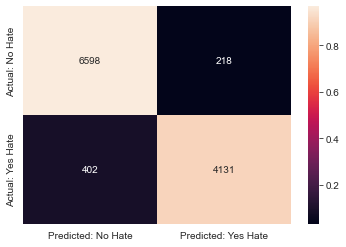

In [39]:
params = {
    'objective': 'binary',
    'is_unbalance': True,
    'metric':'auc'
}

lgb_train = lgb.Dataset(X_train_new, label=y_train_new)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.set_tag("developer", "daniel")
    mlflow.log_param("train-data1-path", os.path.join(config.DATAPATH, 'train.csv'))
    mlflow.log_param("train-data2-path", os.path.join(config.DATAPATH, 'HateSpeechData.csv'))
    mlflow.set_tag("model", "lgb-base")
    
    mlflow.log_params(params)
    basemodel = lgb.train(params, lgb_train,
                          valid_sets=[lgb_test],
                          num_boost_round=1200,
                          early_stopping_rounds=1000,
                          valid_names=['valid']
                         )
    
    train_prob = basemodel.predict(X_train, num_iteration=basemodel.best_iteration)
    test_prob = basemodel.predict(X_test, num_iteration=basemodel.best_iteration)
    
    y_pred = binary_predict(test_prob)
    
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100

    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc})
    mlflow.log_metrics({"test-auc-score":test_auc})

mlflow.end_run()
print(f"Train AUC Score of the basemodel: {train_auc}")
print(f"Test AUC Score of the basemodel: {test_auc}")
print(f"AUC Score of the basemodel: {basemodel.best_score['valid']['auc']}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

***Best Model***

In [28]:
fixed_params = {
        'objective': 'binary',
        'metric':'auc',
        'is_unbalance':True,
        'force_col_wise':True,
        'feature_pre_filter':False,
        'boosting':'dart',
        'num_boost_round':1200,
        'early_stopping_rounds':50,
        'num_threads':4
        }

params = {
    'feature_fraction':0.8,
    'lambda_l1':0.3970341857380282,
    'lambda_l2':0.20506586286248293,
    'learning_rate':0.02624259084185803,
    'max_depth':61,
    'min_data_in_leaf':31,
    'num_leaves':138,
    'seed':43
}

del lgb_train
del lgb_test

lgb_train = lgb.Dataset(X_train_new, label=y_train_new)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-tuning'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})

    lgb_model = lgb.train({**params,**fixed_params}, lgb_train,
                          valid_sets=[lgb_train, lgb_test],
                          valid_names=['train','valid'],
                          num_boost_round=fixed_params["num_boost_round"],
                          early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
    test_prob = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

    y_pred = binary_predict(test_prob)
        
    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100

    mlflow.log_param("percent-misclassified",misclass)
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    mlflow.lightgbm.log_model(lgb_model, artifact_path="models")
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
#     vec_path = './artifacts'
#     with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
#         joblib.dump(tfVectorizer, f)
#     mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")

mlflow.end_run()
print(f"Train AUC Score of the lgb python model: {train_auc}")
print(f"Test AUC Score of the lgb python model: {test_auc}")
print(f"AUC Score of the model: {lgb_model.best_score['valid']['auc']}")

[LightGBM] [Info] Number of positive: 18383, number of negative: 27249
[LightGBM] [Info] Total Bins 51503
[LightGBM] [Info] Number of data points in the train set: 45632, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402853 -> initscore=-0.393590
[LightGBM] [Info] Start training from score -0.393590
[1]	train's auc: 0.93736	valid's auc: 0.930322
[2]	train's auc: 0.970555	valid's auc: 0.964022
[3]	train's auc: 0.97385	valid's auc: 0.967961
[4]	train's auc: 0.973966	valid's auc: 0.968595
[5]	train's auc: 0.969995	valid's auc: 0.964169
[6]	train's auc: 0.970529	valid's auc: 0.96558
[7]	train's auc: 0.973584	valid's auc: 0.968845
[8]	train's auc: 0.973578	valid's auc: 0.968666
[9]	train's auc: 0.974416	valid's auc: 0.969431
[10]	train's auc: 0.974712	valid's auc: 0.96983
[11]	train's auc: 0.975466	valid's auc: 0.970604
[12]	train's auc: 0.975408	valid's auc: 0.970567
[13]	train's auc: 0.975442	valid's auc: 0.970692
[14]	train's auc: 0.975627	valid's auc: 0

[162]	train's auc: 0.982683	valid's auc: 0.976071
[163]	train's auc: 0.982828	valid's auc: 0.976232
[164]	train's auc: 0.982888	valid's auc: 0.976281
[165]	train's auc: 0.982883	valid's auc: 0.976272
[166]	train's auc: 0.982892	valid's auc: 0.976283
[167]	train's auc: 0.983051	valid's auc: 0.976472
[168]	train's auc: 0.98303	valid's auc: 0.976446
[169]	train's auc: 0.983026	valid's auc: 0.976438
[170]	train's auc: 0.98306	valid's auc: 0.976437
[171]	train's auc: 0.983104	valid's auc: 0.976454
[172]	train's auc: 0.983226	valid's auc: 0.976539
[173]	train's auc: 0.983201	valid's auc: 0.976517
[174]	train's auc: 0.983185	valid's auc: 0.976506
[175]	train's auc: 0.983167	valid's auc: 0.976489
[176]	train's auc: 0.983159	valid's auc: 0.976489
[177]	train's auc: 0.983214	valid's auc: 0.976531
[178]	train's auc: 0.983191	valid's auc: 0.976514
[179]	train's auc: 0.983185	valid's auc: 0.976511
[180]	train's auc: 0.983157	valid's auc: 0.976483
[181]	train's auc: 0.983149	valid's auc: 0.976472
[1

[327]	train's auc: 0.986954	valid's auc: 0.978276
[328]	train's auc: 0.986947	valid's auc: 0.978274
[329]	train's auc: 0.986939	valid's auc: 0.978267
[330]	train's auc: 0.986985	valid's auc: 0.978292
[331]	train's auc: 0.98698	valid's auc: 0.978288
[332]	train's auc: 0.986976	valid's auc: 0.978291
[333]	train's auc: 0.986999	valid's auc: 0.97828
[334]	train's auc: 0.986982	valid's auc: 0.978271
[335]	train's auc: 0.987029	valid's auc: 0.978287
[336]	train's auc: 0.98707	valid's auc: 0.978289
[337]	train's auc: 0.987064	valid's auc: 0.978288
[338]	train's auc: 0.987045	valid's auc: 0.97828
[339]	train's auc: 0.98709	valid's auc: 0.978273
[340]	train's auc: 0.987085	valid's auc: 0.978275
[341]	train's auc: 0.987109	valid's auc: 0.978299
[342]	train's auc: 0.987106	valid's auc: 0.9783
[343]	train's auc: 0.987142	valid's auc: 0.978307
[344]	train's auc: 0.987133	valid's auc: 0.9783
[345]	train's auc: 0.987131	valid's auc: 0.9783
[346]	train's auc: 0.987119	valid's auc: 0.978295
[347]	train

[493]	train's auc: 0.989755	valid's auc: 0.979592
[494]	train's auc: 0.989787	valid's auc: 0.979604
[495]	train's auc: 0.98978	valid's auc: 0.979605
[496]	train's auc: 0.989827	valid's auc: 0.979653
[497]	train's auc: 0.989862	valid's auc: 0.979682
[498]	train's auc: 0.989857	valid's auc: 0.979682
[499]	train's auc: 0.989852	valid's auc: 0.979678
[500]	train's auc: 0.98989	valid's auc: 0.979684
[501]	train's auc: 0.989886	valid's auc: 0.979684
[502]	train's auc: 0.989879	valid's auc: 0.979682
[503]	train's auc: 0.989903	valid's auc: 0.979678
[504]	train's auc: 0.989899	valid's auc: 0.979681
[505]	train's auc: 0.989932	valid's auc: 0.979677
[506]	train's auc: 0.989923	valid's auc: 0.979671
[507]	train's auc: 0.989953	valid's auc: 0.979664
[508]	train's auc: 0.989946	valid's auc: 0.97966
[509]	train's auc: 0.989966	valid's auc: 0.979677
[510]	train's auc: 0.990011	valid's auc: 0.979741
[511]	train's auc: 0.990004	valid's auc: 0.979738
[512]	train's auc: 0.989999	valid's auc: 0.979736
[51

[658]	train's auc: 0.992446	valid's auc: 0.980954
[659]	train's auc: 0.992445	valid's auc: 0.980956
[660]	train's auc: 0.992443	valid's auc: 0.980955
[661]	train's auc: 0.992442	valid's auc: 0.980957
[662]	train's auc: 0.992442	valid's auc: 0.980957
[663]	train's auc: 0.992465	valid's auc: 0.980983
[664]	train's auc: 0.992488	valid's auc: 0.980979
[665]	train's auc: 0.99249	valid's auc: 0.980979
[666]	train's auc: 0.992533	valid's auc: 0.980984
[667]	train's auc: 0.992567	valid's auc: 0.981011
[668]	train's auc: 0.992605	valid's auc: 0.981015
[669]	train's auc: 0.992648	valid's auc: 0.981019
[670]	train's auc: 0.992688	valid's auc: 0.981058
[671]	train's auc: 0.992686	valid's auc: 0.98106
[672]	train's auc: 0.992683	valid's auc: 0.981059
[673]	train's auc: 0.992683	valid's auc: 0.98106
[674]	train's auc: 0.992681	valid's auc: 0.981059
[675]	train's auc: 0.992679	valid's auc: 0.981059
[676]	train's auc: 0.992676	valid's auc: 0.981056
[677]	train's auc: 0.992671	valid's auc: 0.981054
[67

[823]	train's auc: 0.994321	valid's auc: 0.981956
[824]	train's auc: 0.994319	valid's auc: 0.981954
[825]	train's auc: 0.994322	valid's auc: 0.981956
[826]	train's auc: 0.994322	valid's auc: 0.981955
[827]	train's auc: 0.994323	valid's auc: 0.981957
[828]	train's auc: 0.994324	valid's auc: 0.981957
[829]	train's auc: 0.994324	valid's auc: 0.981957
[830]	train's auc: 0.994322	valid's auc: 0.981958
[831]	train's auc: 0.994318	valid's auc: 0.981957
[832]	train's auc: 0.994318	valid's auc: 0.981957
[833]	train's auc: 0.994337	valid's auc: 0.981979
[834]	train's auc: 0.994337	valid's auc: 0.981981
[835]	train's auc: 0.994337	valid's auc: 0.981981
[836]	train's auc: 0.994333	valid's auc: 0.981978
[837]	train's auc: 0.994341	valid's auc: 0.981988
[838]	train's auc: 0.994342	valid's auc: 0.981989
[839]	train's auc: 0.994375	valid's auc: 0.981984
[840]	train's auc: 0.994382	valid's auc: 0.981972
[841]	train's auc: 0.994392	valid's auc: 0.981979
[842]	train's auc: 0.994422	valid's auc: 0.981976


[989]	train's auc: 0.995811	valid's auc: 0.982656
[990]	train's auc: 0.995812	valid's auc: 0.982656
[991]	train's auc: 0.995822	valid's auc: 0.982655
[992]	train's auc: 0.995824	valid's auc: 0.982655
[993]	train's auc: 0.995825	valid's auc: 0.982656
[994]	train's auc: 0.995844	valid's auc: 0.982642
[995]	train's auc: 0.995852	valid's auc: 0.982653
[996]	train's auc: 0.995851	valid's auc: 0.982652
[997]	train's auc: 0.995874	valid's auc: 0.982651
[998]	train's auc: 0.995892	valid's auc: 0.982668
[999]	train's auc: 0.995892	valid's auc: 0.982668
[1000]	train's auc: 0.995891	valid's auc: 0.982668
[1001]	train's auc: 0.995892	valid's auc: 0.98267
[1002]	train's auc: 0.995908	valid's auc: 0.982675
[1003]	train's auc: 0.995918	valid's auc: 0.982678
[1004]	train's auc: 0.995927	valid's auc: 0.982682
[1005]	train's auc: 0.995948	valid's auc: 0.982691
[1006]	train's auc: 0.995964	valid's auc: 0.982686
[1007]	train's auc: 0.995964	valid's auc: 0.982686
[1008]	train's auc: 0.995978	valid's auc: 0

[1151]	train's auc: 0.996925	valid's auc: 0.983024
[1152]	train's auc: 0.996926	valid's auc: 0.983026
[1153]	train's auc: 0.996933	valid's auc: 0.983035
[1154]	train's auc: 0.996934	valid's auc: 0.983035
[1155]	train's auc: 0.996957	valid's auc: 0.983037
[1156]	train's auc: 0.996973	valid's auc: 0.983032
[1157]	train's auc: 0.996984	valid's auc: 0.983054
[1158]	train's auc: 0.996985	valid's auc: 0.983053
[1159]	train's auc: 0.996989	valid's auc: 0.983055
[1160]	train's auc: 0.996998	valid's auc: 0.983058
[1161]	train's auc: 0.997001	valid's auc: 0.98306
[1162]	train's auc: 0.997001	valid's auc: 0.983059
[1163]	train's auc: 0.997007	valid's auc: 0.983066
[1164]	train's auc: 0.997019	valid's auc: 0.983085
[1165]	train's auc: 0.997019	valid's auc: 0.983086
[1166]	train's auc: 0.997018	valid's auc: 0.983086
[1167]	train's auc: 0.99702	valid's auc: 0.983088
[1168]	train's auc: 0.997028	valid's auc: 0.983082
[1169]	train's auc: 0.99703	valid's auc: 0.983081
[1170]	train's auc: 0.997032	valid

Train AUC Score of the lgb python model: 0.997186740711192
Test AUC Score of the lgb python model: 0.9831479200780091
'%' of Misclassified class: 5.251564014450612


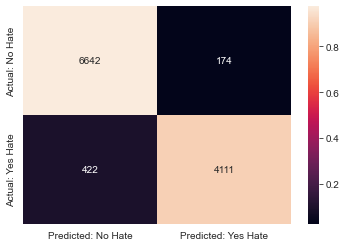

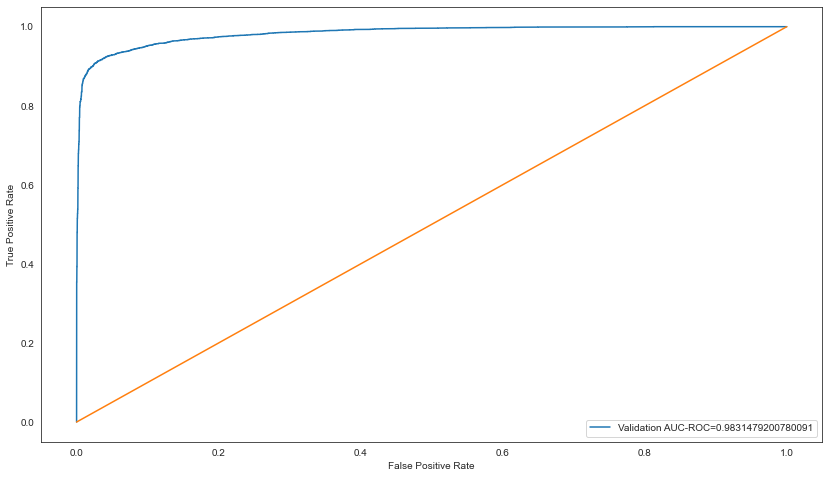

,Actual Label,Predicted_class,Probability
0,0,0,0.079679
1,0,0,0.066519
2,1,1,0.996308
3,0,0,0.004467
4,0,0,0.064061
5,0,1,0.542467
6,0,0,0.445731
7,0,0,0.008540
8,0,0,0.008965
9,1,1,0.997127


In [29]:
train_auc = roc_auc_score(y_train, train_prob)
test_auc = roc_auc_score(y_test, test_prob)
misclass = np.mean(y_pred != y_test)*100
print(f"Train AUC Score of the lgb python model: {train_auc}")
print(f"Test AUC Score of the lgb python model: {test_auc}")
print("'%' of Misclassified class:",misclass)

cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

# Apply SMOTE to new data

In [94]:
print(X_train_new.shape)
print(y_train_new.shape)
print(Counter(y_train_new))

(45695, 1018)
(45695,)
Counter({0: 27290, 1: 18405})


In [30]:
X_train_new_ada, y_train_new_ada = ADASYN(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_ada.shape)
print(y_train_new_ada.shape)
print(Counter(y_train_new_ada))

(54753, 1018)
(54753,)
Counter({1: 27504, 0: 27249})


[LightGBM] [Info] Number of positive: 27504, number of negative: 27249
[LightGBM] [Info] Total Bins 71521
[LightGBM] [Info] Number of data points in the train set: 54753, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502329 -> initscore=0.009315
[LightGBM] [Info] Start training from score 0.009315
[1]	train's auc: 0.948552	valid's auc: 0.930425
[2]	train's auc: 0.976841	valid's auc: 0.964795
[3]	train's auc: 0.980278	valid's auc: 0.968582
[4]	train's auc: 0.980217	valid's auc: 0.969244
[5]	train's auc: 0.977863	valid's auc: 0.965213
[6]	train's auc: 0.97828	valid's auc: 0.966618
[7]	train's auc: 0.98052	valid's auc: 0.968931
[8]	train's auc: 0.980561	valid's auc: 0.968989
[9]	train's auc: 0.981044	valid's auc: 0.96955
[10]	train's auc: 0.981202	valid's auc: 0.969743
[11]	train's auc: 0.981732	valid's auc: 0.970256
[12]	train's auc: 0.981807	valid's auc: 0.97051
[13]	train's auc: 0.981784	valid's auc: 0.970738
[14]	train's auc: 0.981979	valid's auc: 0.9

[165]	train's auc: 0.987066	valid's auc: 0.975694
[166]	train's auc: 0.987069	valid's auc: 0.975699
[167]	train's auc: 0.987207	valid's auc: 0.975899
[168]	train's auc: 0.987186	valid's auc: 0.975875
[169]	train's auc: 0.987181	valid's auc: 0.975875
[170]	train's auc: 0.987187	valid's auc: 0.975894
[171]	train's auc: 0.987219	valid's auc: 0.975895
[172]	train's auc: 0.9873	valid's auc: 0.975963
[173]	train's auc: 0.987281	valid's auc: 0.975948
[174]	train's auc: 0.98727	valid's auc: 0.975939
[175]	train's auc: 0.987258	valid's auc: 0.975932
[176]	train's auc: 0.987255	valid's auc: 0.975934
[177]	train's auc: 0.987308	valid's auc: 0.975997
[178]	train's auc: 0.987289	valid's auc: 0.975978
[179]	train's auc: 0.987285	valid's auc: 0.975977
[180]	train's auc: 0.987263	valid's auc: 0.975955
[181]	train's auc: 0.987257	valid's auc: 0.975945
[182]	train's auc: 0.987256	valid's auc: 0.975944
[183]	train's auc: 0.987253	valid's auc: 0.975934
[184]	train's auc: 0.987255	valid's auc: 0.975938
[18

[331]	train's auc: 0.989934	valid's auc: 0.977647
[332]	train's auc: 0.989931	valid's auc: 0.977648
[333]	train's auc: 0.989949	valid's auc: 0.977664
[334]	train's auc: 0.989938	valid's auc: 0.977661
[335]	train's auc: 0.989972	valid's auc: 0.977682
[336]	train's auc: 0.990007	valid's auc: 0.977679
[337]	train's auc: 0.990002	valid's auc: 0.977681
[338]	train's auc: 0.989989	valid's auc: 0.977674
[339]	train's auc: 0.99003	valid's auc: 0.977666
[340]	train's auc: 0.990027	valid's auc: 0.977667
[341]	train's auc: 0.990066	valid's auc: 0.977677
[342]	train's auc: 0.990064	valid's auc: 0.977681
[343]	train's auc: 0.990094	valid's auc: 0.977684
[344]	train's auc: 0.990088	valid's auc: 0.97768
[345]	train's auc: 0.990087	valid's auc: 0.977679
[346]	train's auc: 0.990077	valid's auc: 0.977672
[347]	train's auc: 0.990111	valid's auc: 0.977696
[348]	train's auc: 0.990126	valid's auc: 0.977715
[349]	train's auc: 0.990149	valid's auc: 0.977738
[350]	train's auc: 0.990143	valid's auc: 0.97774
[35

[498]	train's auc: 0.992054	valid's auc: 0.97901
[499]	train's auc: 0.99205	valid's auc: 0.979006
[500]	train's auc: 0.992066	valid's auc: 0.979016
[501]	train's auc: 0.992063	valid's auc: 0.979015
[502]	train's auc: 0.992059	valid's auc: 0.979014
[503]	train's auc: 0.992074	valid's auc: 0.979026
[504]	train's auc: 0.992072	valid's auc: 0.979026
[505]	train's auc: 0.992084	valid's auc: 0.978999
[506]	train's auc: 0.992078	valid's auc: 0.978996
[507]	train's auc: 0.9921	valid's auc: 0.978998
[508]	train's auc: 0.992095	valid's auc: 0.978993
[509]	train's auc: 0.992133	valid's auc: 0.97902
[510]	train's auc: 0.992165	valid's auc: 0.979043
[511]	train's auc: 0.992161	valid's auc: 0.97904
[512]	train's auc: 0.992158	valid's auc: 0.979038
[513]	train's auc: 0.992156	valid's auc: 0.979038
[514]	train's auc: 0.992177	valid's auc: 0.979042
[515]	train's auc: 0.992186	valid's auc: 0.979057
[516]	train's auc: 0.992184	valid's auc: 0.979056
[517]	train's auc: 0.992217	valid's auc: 0.979066
[518]	

[665]	train's auc: 0.994167	valid's auc: 0.980484
[666]	train's auc: 0.994191	valid's auc: 0.98047
[667]	train's auc: 0.994219	valid's auc: 0.980455
[668]	train's auc: 0.994243	valid's auc: 0.980449
[669]	train's auc: 0.994271	valid's auc: 0.980446
[670]	train's auc: 0.994294	valid's auc: 0.980436
[671]	train's auc: 0.994292	valid's auc: 0.980437
[672]	train's auc: 0.994291	valid's auc: 0.980436
[673]	train's auc: 0.994291	valid's auc: 0.980434
[674]	train's auc: 0.994291	valid's auc: 0.980434
[675]	train's auc: 0.994289	valid's auc: 0.980434
[676]	train's auc: 0.994287	valid's auc: 0.980433
[677]	train's auc: 0.994285	valid's auc: 0.980434
[678]	train's auc: 0.994307	valid's auc: 0.980472
[679]	train's auc: 0.994333	valid's auc: 0.98049
[680]	train's auc: 0.994361	valid's auc: 0.980502
[681]	train's auc: 0.994385	valid's auc: 0.980545
[682]	train's auc: 0.994404	valid's auc: 0.980574
[683]	train's auc: 0.994404	valid's auc: 0.980572
[684]	train's auc: 0.994402	valid's auc: 0.980572
[6

[830]	train's auc: 0.995616	valid's auc: 0.981577
[831]	train's auc: 0.995613	valid's auc: 0.981579
[832]	train's auc: 0.995613	valid's auc: 0.981579
[833]	train's auc: 0.995628	valid's auc: 0.98158
[834]	train's auc: 0.995629	valid's auc: 0.981582
[835]	train's auc: 0.995629	valid's auc: 0.981582
[836]	train's auc: 0.995626	valid's auc: 0.98158
[837]	train's auc: 0.99564	valid's auc: 0.981577
[838]	train's auc: 0.99564	valid's auc: 0.981579
[839]	train's auc: 0.995654	valid's auc: 0.981591
[840]	train's auc: 0.995663	valid's auc: 0.981592
[841]	train's auc: 0.995672	valid's auc: 0.98159
[842]	train's auc: 0.995691	valid's auc: 0.981587
[843]	train's auc: 0.995691	valid's auc: 0.981587
[844]	train's auc: 0.995691	valid's auc: 0.981588
[845]	train's auc: 0.995691	valid's auc: 0.98159
[846]	train's auc: 0.995692	valid's auc: 0.981592
[847]	train's auc: 0.995698	valid's auc: 0.981583
[848]	train's auc: 0.9957	valid's auc: 0.981585
[849]	train's auc: 0.995715	valid's auc: 0.981582
[850]	tr

[996]	train's auc: 0.996791	valid's auc: 0.982441
[997]	train's auc: 0.996809	valid's auc: 0.982449
[998]	train's auc: 0.996822	valid's auc: 0.982472
[999]	train's auc: 0.996822	valid's auc: 0.982473
[1000]	train's auc: 0.996822	valid's auc: 0.982472
[1001]	train's auc: 0.996823	valid's auc: 0.982473
[1002]	train's auc: 0.996832	valid's auc: 0.982474
[1003]	train's auc: 0.996853	valid's auc: 0.982482
[1004]	train's auc: 0.996861	valid's auc: 0.982491
[1005]	train's auc: 0.996873	valid's auc: 0.982494
[1006]	train's auc: 0.996885	valid's auc: 0.982499
[1007]	train's auc: 0.996885	valid's auc: 0.982499
[1008]	train's auc: 0.996897	valid's auc: 0.98253
[1009]	train's auc: 0.996907	valid's auc: 0.982546
[1010]	train's auc: 0.996907	valid's auc: 0.982548
[1011]	train's auc: 0.996907	valid's auc: 0.982548
[1012]	train's auc: 0.996918	valid's auc: 0.982565
[1013]	train's auc: 0.996919	valid's auc: 0.982565
[1014]	train's auc: 0.996919	valid's auc: 0.982567
[1015]	train's auc: 0.996927	valid's

[1158]	train's auc: 0.997668	valid's auc: 0.982913
[1159]	train's auc: 0.99767	valid's auc: 0.982919
[1160]	train's auc: 0.997676	valid's auc: 0.982925
[1161]	train's auc: 0.997678	valid's auc: 0.982925
[1162]	train's auc: 0.997678	valid's auc: 0.982927
[1163]	train's auc: 0.997681	valid's auc: 0.982935
[1164]	train's auc: 0.997686	valid's auc: 0.982938
[1165]	train's auc: 0.997687	valid's auc: 0.982939
[1166]	train's auc: 0.997687	valid's auc: 0.98294
[1167]	train's auc: 0.997688	valid's auc: 0.98294
[1168]	train's auc: 0.997698	valid's auc: 0.982944
[1169]	train's auc: 0.997699	valid's auc: 0.982944
[1170]	train's auc: 0.997701	valid's auc: 0.982945
[1171]	train's auc: 0.997703	valid's auc: 0.982946
[1172]	train's auc: 0.997704	valid's auc: 0.982947
[1173]	train's auc: 0.997705	valid's auc: 0.982948
[1174]	train's auc: 0.997708	valid's auc: 0.982947
[1175]	train's auc: 0.997719	valid's auc: 0.982941
[1176]	train's auc: 0.997725	valid's auc: 0.982948
[1177]	train's auc: 0.997727	valid

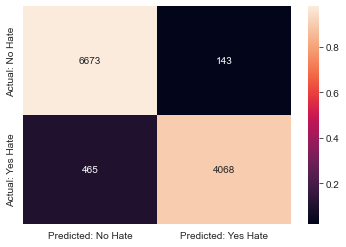

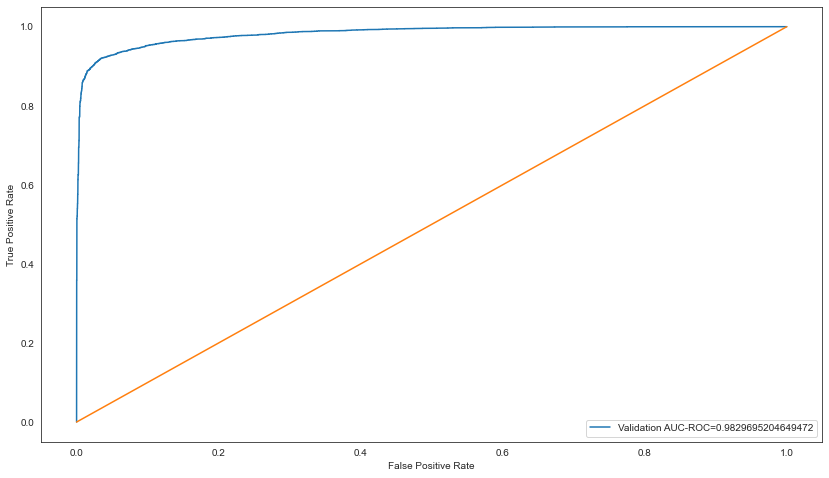

,Actual Label,Predicted_class,Probability
0,0,0,0.065450
1,0,0,0.053470
2,1,1,0.997372
3,0,0,0.004483
4,0,0,0.051145
5,0,0,0.486993
6,0,0,0.379061
7,0,0,0.005859
8,0,0,0.006426
9,1,1,0.997456


In [31]:
del lgb_train
del lgb_test

lgb_train_new_ada = lgb.Dataset(X_train_new_ada, label=y_train_new_ada)
lgb_test_new_ada = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_ada)

fixed_params = {
        'objective': 'binary',
        'metric':'auc',
        'is_unbalance':True,
        'force_col_wise':True,
        'feature_pre_filter':False,
        'boosting':'dart',
        'num_boost_round':1200,
        'early_stopping_rounds':50,
        'num_threads':4
        }

params = {
    'feature_fraction':0.8,
    'lambda_l1':0.3970341857380282,
    'lambda_l2':0.20506586286248293,
    'learning_rate':0.02624259084185803,
    'max_depth':61,
    'min_data_in_leaf':31,
    'num_leaves':138,
    'seed':43
}

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-ada'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
        
    lgb_model_ada = lgb.train({**params,**fixed_params}, lgb_train_new_ada,
                             valid_sets=[lgb_train_new_ada, lgb_test_new_ada],
                             valid_names=['train','valid'],
                             num_boost_round=fixed_params["num_boost_round"],
                             early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_ada.predict(X_train, num_iteration=lgb_model_ada.best_iteration)
    test_prob = lgb_model_ada.predict(X_test, num_iteration=lgb_model_ada.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass,
                     "SMOTE":'ada'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
mlflow.end_run()
print(f"Train ROC AUC LGBM Model Score with ADASYN: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score with ADASYN: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

(54498, 1018)
(54498,)
Counter({0: 27249, 1: 27249})
[LightGBM] [Info] Number of positive: 27249, number of negative: 27249
[LightGBM] [Info] Total Bins 70762
[LightGBM] [Info] Number of data points in the train set: 54498, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	train's auc: 0.947554	valid's auc: 0.929556
[2]	train's auc: 0.976398	valid's auc: 0.964699
[3]	train's auc: 0.979986	valid's auc: 0.96847
[4]	train's auc: 0.980026	valid's auc: 0.969073
[5]	train's auc: 0.977682	valid's auc: 0.965567
[6]	train's auc: 0.978013	valid's auc: 0.96667
[7]	train's auc: 0.98021	valid's auc: 0.96904
[8]	train's auc: 0.980298	valid's auc: 0.969078
[9]	train's auc: 0.98088	valid's auc: 0.969599
[10]	train's auc: 0.981099	valid's auc: 0.969768
[11]	train's auc: 0.981566	valid's auc: 0.970162
[12]	train's auc: 0.981656	valid's auc: 0.970522
[13]	train's auc: 0.981669	valid's auc: 0.97074
[14]	train's auc: 0.981808	valid's auc: 0.970

[165]	train's auc: 0.986967	valid's auc: 0.975591
[166]	train's auc: 0.986971	valid's auc: 0.975597
[167]	train's auc: 0.987103	valid's auc: 0.975752
[168]	train's auc: 0.987075	valid's auc: 0.975723
[169]	train's auc: 0.987069	valid's auc: 0.975717
[170]	train's auc: 0.9871	valid's auc: 0.975697
[171]	train's auc: 0.987116	valid's auc: 0.975739
[172]	train's auc: 0.987214	valid's auc: 0.975826
[173]	train's auc: 0.987196	valid's auc: 0.975811
[174]	train's auc: 0.987184	valid's auc: 0.975801
[175]	train's auc: 0.987173	valid's auc: 0.975782
[176]	train's auc: 0.987167	valid's auc: 0.975781
[177]	train's auc: 0.987209	valid's auc: 0.975814
[178]	train's auc: 0.987191	valid's auc: 0.975792
[179]	train's auc: 0.987187	valid's auc: 0.975787
[180]	train's auc: 0.987165	valid's auc: 0.975765
[181]	train's auc: 0.987159	valid's auc: 0.975755
[182]	train's auc: 0.987161	valid's auc: 0.975751
[183]	train's auc: 0.987159	valid's auc: 0.975744
[184]	train's auc: 0.987165	valid's auc: 0.975746
[1

[331]	train's auc: 0.989783	valid's auc: 0.977501
[332]	train's auc: 0.98978	valid's auc: 0.977502
[333]	train's auc: 0.989817	valid's auc: 0.977486
[334]	train's auc: 0.989806	valid's auc: 0.977479
[335]	train's auc: 0.989855	valid's auc: 0.977497
[336]	train's auc: 0.989889	valid's auc: 0.977521
[337]	train's auc: 0.989885	valid's auc: 0.977517
[338]	train's auc: 0.989874	valid's auc: 0.97751
[339]	train's auc: 0.989905	valid's auc: 0.977523
[340]	train's auc: 0.989903	valid's auc: 0.977525
[341]	train's auc: 0.989928	valid's auc: 0.977523
[342]	train's auc: 0.989927	valid's auc: 0.977522
[343]	train's auc: 0.98995	valid's auc: 0.977552
[344]	train's auc: 0.989944	valid's auc: 0.977547
[345]	train's auc: 0.989943	valid's auc: 0.97755
[346]	train's auc: 0.989934	valid's auc: 0.977542
[347]	train's auc: 0.989968	valid's auc: 0.977568
[348]	train's auc: 0.990002	valid's auc: 0.97759
[349]	train's auc: 0.990034	valid's auc: 0.977595
[350]	train's auc: 0.990029	valid's auc: 0.977592
[351]

[498]	train's auc: 0.99199	valid's auc: 0.978856
[499]	train's auc: 0.991986	valid's auc: 0.978853
[500]	train's auc: 0.992006	valid's auc: 0.978872
[501]	train's auc: 0.992003	valid's auc: 0.978872
[502]	train's auc: 0.991999	valid's auc: 0.978873
[503]	train's auc: 0.992016	valid's auc: 0.978876
[504]	train's auc: 0.992014	valid's auc: 0.978878
[505]	train's auc: 0.992036	valid's auc: 0.978887
[506]	train's auc: 0.99203	valid's auc: 0.978885
[507]	train's auc: 0.992054	valid's auc: 0.978916
[508]	train's auc: 0.992049	valid's auc: 0.978911
[509]	train's auc: 0.992066	valid's auc: 0.978913
[510]	train's auc: 0.992096	valid's auc: 0.978938
[511]	train's auc: 0.992091	valid's auc: 0.978938
[512]	train's auc: 0.992087	valid's auc: 0.978933
[513]	train's auc: 0.992085	valid's auc: 0.978932
[514]	train's auc: 0.992105	valid's auc: 0.97892
[515]	train's auc: 0.992126	valid's auc: 0.978926
[516]	train's auc: 0.992125	valid's auc: 0.978924
[517]	train's auc: 0.992172	valid's auc: 0.978953
[51

[665]	train's auc: 0.994096	valid's auc: 0.980533
[666]	train's auc: 0.994119	valid's auc: 0.980524
[667]	train's auc: 0.994147	valid's auc: 0.980551
[668]	train's auc: 0.99417	valid's auc: 0.980558
[669]	train's auc: 0.994199	valid's auc: 0.980553
[670]	train's auc: 0.994223	valid's auc: 0.980545
[671]	train's auc: 0.994222	valid's auc: 0.980545
[672]	train's auc: 0.994221	valid's auc: 0.980545
[673]	train's auc: 0.994222	valid's auc: 0.980546
[674]	train's auc: 0.994221	valid's auc: 0.980545
[675]	train's auc: 0.99422	valid's auc: 0.980545
[676]	train's auc: 0.994218	valid's auc: 0.980544
[677]	train's auc: 0.994215	valid's auc: 0.980542
[678]	train's auc: 0.994247	valid's auc: 0.980576
[679]	train's auc: 0.99426	valid's auc: 0.980558
[680]	train's auc: 0.994284	valid's auc: 0.980574
[681]	train's auc: 0.99432	valid's auc: 0.980588
[682]	train's auc: 0.994335	valid's auc: 0.98059
[683]	train's auc: 0.994335	valid's auc: 0.980589
[684]	train's auc: 0.994334	valid's auc: 0.980589
[685]

[830]	train's auc: 0.99559	valid's auc: 0.981573
[831]	train's auc: 0.995588	valid's auc: 0.981574
[832]	train's auc: 0.995588	valid's auc: 0.981575
[833]	train's auc: 0.995601	valid's auc: 0.981571
[834]	train's auc: 0.995602	valid's auc: 0.981571
[835]	train's auc: 0.995602	valid's auc: 0.981571
[836]	train's auc: 0.995598	valid's auc: 0.981568
[837]	train's auc: 0.995605	valid's auc: 0.981579
[838]	train's auc: 0.995606	valid's auc: 0.981581
[839]	train's auc: 0.995619	valid's auc: 0.981589
[840]	train's auc: 0.995631	valid's auc: 0.981598
[841]	train's auc: 0.995642	valid's auc: 0.981596
[842]	train's auc: 0.995664	valid's auc: 0.981602
[843]	train's auc: 0.995663	valid's auc: 0.981602
[844]	train's auc: 0.995664	valid's auc: 0.981603
[845]	train's auc: 0.995664	valid's auc: 0.981605
[846]	train's auc: 0.995665	valid's auc: 0.981606
[847]	train's auc: 0.995677	valid's auc: 0.981596
[848]	train's auc: 0.995678	valid's auc: 0.981598
[849]	train's auc: 0.995696	valid's auc: 0.981604
[

[996]	train's auc: 0.996752	valid's auc: 0.982403
[997]	train's auc: 0.996769	valid's auc: 0.98242
[998]	train's auc: 0.99679	valid's auc: 0.982432
[999]	train's auc: 0.99679	valid's auc: 0.982432
[1000]	train's auc: 0.99679	valid's auc: 0.982432
[1001]	train's auc: 0.996792	valid's auc: 0.982434
[1002]	train's auc: 0.996801	valid's auc: 0.982445
[1003]	train's auc: 0.996815	valid's auc: 0.982466
[1004]	train's auc: 0.996823	valid's auc: 0.982457
[1005]	train's auc: 0.996836	valid's auc: 0.982469
[1006]	train's auc: 0.996849	valid's auc: 0.982482
[1007]	train's auc: 0.996848	valid's auc: 0.982483
[1008]	train's auc: 0.99686	valid's auc: 0.982508
[1009]	train's auc: 0.996871	valid's auc: 0.982517
[1010]	train's auc: 0.996871	valid's auc: 0.982517
[1011]	train's auc: 0.996871	valid's auc: 0.982517
[1012]	train's auc: 0.996883	valid's auc: 0.982548
[1013]	train's auc: 0.996884	valid's auc: 0.982548
[1014]	train's auc: 0.996884	valid's auc: 0.982548
[1015]	train's auc: 0.996894	valid's auc

[1158]	train's auc: 0.997619	valid's auc: 0.98294
[1159]	train's auc: 0.997623	valid's auc: 0.982951
[1160]	train's auc: 0.997626	valid's auc: 0.982963
[1161]	train's auc: 0.997628	valid's auc: 0.982964
[1162]	train's auc: 0.997629	valid's auc: 0.982963
[1163]	train's auc: 0.997632	valid's auc: 0.982959
[1164]	train's auc: 0.997638	valid's auc: 0.982968
[1165]	train's auc: 0.997638	valid's auc: 0.982969
[1166]	train's auc: 0.997638	valid's auc: 0.982969
[1167]	train's auc: 0.997639	valid's auc: 0.98297
[1168]	train's auc: 0.997644	valid's auc: 0.982977
[1169]	train's auc: 0.997645	valid's auc: 0.982977
[1170]	train's auc: 0.997647	valid's auc: 0.982979
[1171]	train's auc: 0.997649	valid's auc: 0.982981
[1172]	train's auc: 0.997651	valid's auc: 0.982982
[1173]	train's auc: 0.997651	valid's auc: 0.982982
[1174]	train's auc: 0.997658	valid's auc: 0.982987
[1175]	train's auc: 0.997667	valid's auc: 0.982991
[1176]	train's auc: 0.99768	valid's auc: 0.983004
[1177]	train's auc: 0.997684	valid

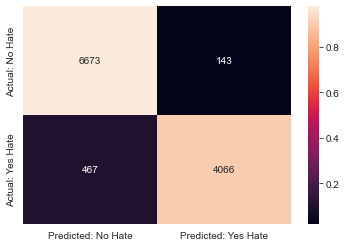

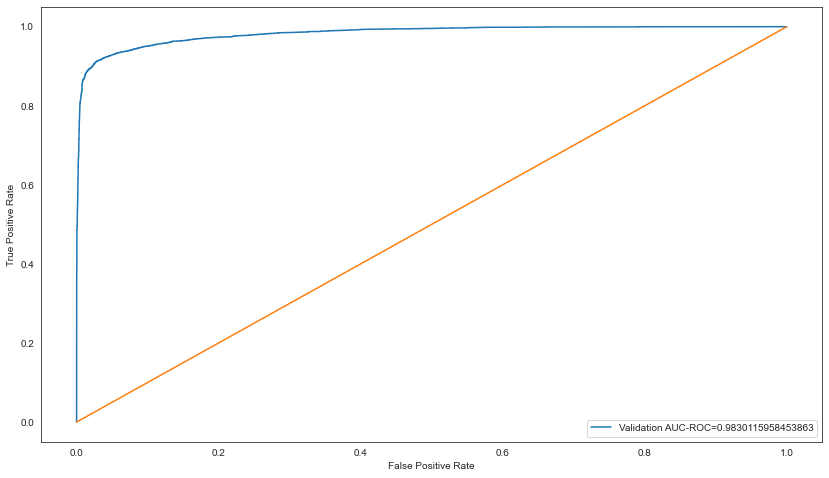

,Actual Label,Predicted_class,Probability
0,0,0,0.068813
1,0,0,0.070721
2,1,1,0.997129
3,0,0,0.004340
4,0,0,0.054723
5,0,0,0.400032
6,0,0,0.422358
7,0,0,0.005737
8,0,0,0.006041
9,1,1,0.997236


In [32]:
X_train_new_bls, y_train_new_bls = BorderlineSMOTE(random_state = 43).fit_resample(X_train_new, y_train_new)
print(X_train_new_bls.shape)
print(y_train_new_bls.shape)
print(Counter(y_train_new_bls))

lgb_train_new_bls = lgb.Dataset(X_train_new_bls, label=y_train_new_bls)
lgb_test_new_bls = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_bls)

with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-bls'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
    
    lgb_model_bls = lgb.train({**params,**fixed_params}, lgb_train_new_bls,
                              valid_sets=[lgb_train_new_bls, lgb_test_new_bls],
                              valid_names=['train','valid'],
                              num_boost_round=fixed_params["num_boost_round"],
                              early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_bls.predict(X_train, num_iteration=lgb_model_bls.best_iteration)
    test_prob = lgb_model_bls.predict(X_test, num_iteration=lgb_model_bls.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass,
                       "SMOTE":'bls'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    vec_path = './artifacts'
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")

mlflow.end_run()
print(f"Train ROC AUC LGBM Model Score before Semi-Supervised Learning: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score before Semi-Supervised Learning: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

In [33]:
smote_pipe = Pipeline([('over', SMOTE(random_state = 11, sampling_strategy=0.8)),
                     ('under', RandomUnderSampler(sampling_strategy=0.9))]
                   )

X_train_new_sm, y_train_new_sm = smote_pipe.fit_resample(X_train_new, y_train_new)
print(X_train_new_sm.shape)
print(y_train_new_sm.shape)
print(Counter(y_train_new_sm))

(46020, 1018)
(46020,)
Counter({0: 24221, 1: 21799})


[LightGBM] [Info] Number of positive: 21799, number of negative: 24221
[LightGBM] [Info] Total Bins 58401
[LightGBM] [Info] Number of data points in the train set: 46020, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473685 -> initscore=-0.105356
[LightGBM] [Info] Start training from score -0.105356
[1]	train's auc: 0.942861	valid's auc: 0.928849
[2]	train's auc: 0.973348	valid's auc: 0.963385
[3]	train's auc: 0.976906	valid's auc: 0.968365
[4]	train's auc: 0.976968	valid's auc: 0.968574
[5]	train's auc: 0.97363	valid's auc: 0.964047
[6]	train's auc: 0.974174	valid's auc: 0.965615
[7]	train's auc: 0.976421	valid's auc: 0.967956
[8]	train's auc: 0.976443	valid's auc: 0.96791
[9]	train's auc: 0.977125	valid's auc: 0.968517
[10]	train's auc: 0.97739	valid's auc: 0.969024
[11]	train's auc: 0.97811	valid's auc: 0.969956
[12]	train's auc: 0.978176	valid's auc: 0.970042
[13]	train's auc: 0.978246	valid's auc: 0.970282
[14]	train's auc: 0.978359	valid's auc: 0

[162]	train's auc: 0.984526	valid's auc: 0.975473
[163]	train's auc: 0.984669	valid's auc: 0.9757
[164]	train's auc: 0.984701	valid's auc: 0.975711
[165]	train's auc: 0.984697	valid's auc: 0.975695
[166]	train's auc: 0.984704	valid's auc: 0.975701
[167]	train's auc: 0.984876	valid's auc: 0.975905
[168]	train's auc: 0.984837	valid's auc: 0.975877
[169]	train's auc: 0.984833	valid's auc: 0.975866
[170]	train's auc: 0.984872	valid's auc: 0.975873
[171]	train's auc: 0.984917	valid's auc: 0.975913
[172]	train's auc: 0.985051	valid's auc: 0.975973
[173]	train's auc: 0.985025	valid's auc: 0.975945
[174]	train's auc: 0.985007	valid's auc: 0.975942
[175]	train's auc: 0.984989	valid's auc: 0.975922
[176]	train's auc: 0.984986	valid's auc: 0.975921
[177]	train's auc: 0.985038	valid's auc: 0.975959
[178]	train's auc: 0.985013	valid's auc: 0.975942
[179]	train's auc: 0.985007	valid's auc: 0.97594
[180]	train's auc: 0.984979	valid's auc: 0.975917
[181]	train's auc: 0.984972	valid's auc: 0.975907
[18

[326]	train's auc: 0.988218	valid's auc: 0.977771
[327]	train's auc: 0.98821	valid's auc: 0.977766
[328]	train's auc: 0.988205	valid's auc: 0.977764
[329]	train's auc: 0.988197	valid's auc: 0.977761
[330]	train's auc: 0.988221	valid's auc: 0.97774
[331]	train's auc: 0.988217	valid's auc: 0.977739
[332]	train's auc: 0.988213	valid's auc: 0.977739
[333]	train's auc: 0.988246	valid's auc: 0.977724
[334]	train's auc: 0.988233	valid's auc: 0.977714
[335]	train's auc: 0.988282	valid's auc: 0.977737
[336]	train's auc: 0.988323	valid's auc: 0.97774
[337]	train's auc: 0.988316	valid's auc: 0.977741
[338]	train's auc: 0.9883	valid's auc: 0.97773
[339]	train's auc: 0.988333	valid's auc: 0.977738
[340]	train's auc: 0.98833	valid's auc: 0.977739
[341]	train's auc: 0.988363	valid's auc: 0.977727
[342]	train's auc: 0.988361	valid's auc: 0.977732
[343]	train's auc: 0.988378	valid's auc: 0.977713
[344]	train's auc: 0.988371	valid's auc: 0.977709
[345]	train's auc: 0.988371	valid's auc: 0.977707
[346]	t

[491]	train's auc: 0.990705	valid's auc: 0.979098
[492]	train's auc: 0.990783	valid's auc: 0.979193
[493]	train's auc: 0.990774	valid's auc: 0.979185
[494]	train's auc: 0.990804	valid's auc: 0.97919
[495]	train's auc: 0.990798	valid's auc: 0.979188
[496]	train's auc: 0.990849	valid's auc: 0.979187
[497]	train's auc: 0.990885	valid's auc: 0.979219
[498]	train's auc: 0.99088	valid's auc: 0.979217
[499]	train's auc: 0.990875	valid's auc: 0.979213
[500]	train's auc: 0.990895	valid's auc: 0.979219
[501]	train's auc: 0.990893	valid's auc: 0.979218
[502]	train's auc: 0.990887	valid's auc: 0.979217
[503]	train's auc: 0.99092	valid's auc: 0.9792
[504]	train's auc: 0.990917	valid's auc: 0.9792
[505]	train's auc: 0.99094	valid's auc: 0.979211
[506]	train's auc: 0.990931	valid's auc: 0.979206
[507]	train's auc: 0.990948	valid's auc: 0.979212
[508]	train's auc: 0.990942	valid's auc: 0.97921
[509]	train's auc: 0.990971	valid's auc: 0.979217
[510]	train's auc: 0.991013	valid's auc: 0.979256
[511]	tra

[657]	train's auc: 0.993356	valid's auc: 0.980714
[658]	train's auc: 0.993354	valid's auc: 0.980715
[659]	train's auc: 0.993352	valid's auc: 0.980717
[660]	train's auc: 0.993351	valid's auc: 0.980717
[661]	train's auc: 0.993351	valid's auc: 0.980719
[662]	train's auc: 0.99335	valid's auc: 0.98072
[663]	train's auc: 0.993381	valid's auc: 0.980743
[664]	train's auc: 0.993404	valid's auc: 0.980744
[665]	train's auc: 0.993406	valid's auc: 0.980746
[666]	train's auc: 0.99342	valid's auc: 0.980766
[667]	train's auc: 0.993448	valid's auc: 0.980766
[668]	train's auc: 0.993478	valid's auc: 0.980779
[669]	train's auc: 0.993502	valid's auc: 0.980759
[670]	train's auc: 0.993537	valid's auc: 0.980803
[671]	train's auc: 0.993535	valid's auc: 0.980804
[672]	train's auc: 0.993533	valid's auc: 0.980804
[673]	train's auc: 0.993533	valid's auc: 0.980804
[674]	train's auc: 0.993532	valid's auc: 0.980803
[675]	train's auc: 0.993529	valid's auc: 0.980804
[676]	train's auc: 0.993527	valid's auc: 0.980803
[67

[822]	train's auc: 0.995051	valid's auc: 0.981785
[823]	train's auc: 0.995049	valid's auc: 0.981786
[824]	train's auc: 0.995048	valid's auc: 0.981786
[825]	train's auc: 0.995051	valid's auc: 0.981788
[826]	train's auc: 0.995051	valid's auc: 0.981787
[827]	train's auc: 0.995051	valid's auc: 0.981789
[828]	train's auc: 0.995052	valid's auc: 0.981789
[829]	train's auc: 0.995052	valid's auc: 0.981791
[830]	train's auc: 0.995052	valid's auc: 0.981792
[831]	train's auc: 0.995047	valid's auc: 0.98179
[832]	train's auc: 0.995048	valid's auc: 0.98179
[833]	train's auc: 0.99506	valid's auc: 0.981794
[834]	train's auc: 0.99506	valid's auc: 0.981796
[835]	train's auc: 0.99506	valid's auc: 0.981795
[836]	train's auc: 0.995056	valid's auc: 0.981793
[837]	train's auc: 0.995066	valid's auc: 0.981807
[838]	train's auc: 0.995067	valid's auc: 0.981807
[839]	train's auc: 0.995082	valid's auc: 0.981808
[840]	train's auc: 0.995094	valid's auc: 0.981811
[841]	train's auc: 0.995107	valid's auc: 0.981811
[842]

[989]	train's auc: 0.996364	valid's auc: 0.982505
[990]	train's auc: 0.996365	valid's auc: 0.982505
[991]	train's auc: 0.99637	valid's auc: 0.982512
[992]	train's auc: 0.996371	valid's auc: 0.982514
[993]	train's auc: 0.996373	valid's auc: 0.982515
[994]	train's auc: 0.996393	valid's auc: 0.982514
[995]	train's auc: 0.996401	valid's auc: 0.98252
[996]	train's auc: 0.9964	valid's auc: 0.98252
[997]	train's auc: 0.996423	valid's auc: 0.982526
[998]	train's auc: 0.996438	valid's auc: 0.982556
[999]	train's auc: 0.996438	valid's auc: 0.982556
[1000]	train's auc: 0.996437	valid's auc: 0.982555
[1001]	train's auc: 0.996439	valid's auc: 0.982556
[1002]	train's auc: 0.996454	valid's auc: 0.982537
[1003]	train's auc: 0.996462	valid's auc: 0.982554
[1004]	train's auc: 0.99648	valid's auc: 0.982544
[1005]	train's auc: 0.996499	valid's auc: 0.982572
[1006]	train's auc: 0.996517	valid's auc: 0.982581
[1007]	train's auc: 0.996516	valid's auc: 0.982581
[1008]	train's auc: 0.996532	valid's auc: 0.9825

[1151]	train's auc: 0.99732	valid's auc: 0.982862
[1152]	train's auc: 0.997321	valid's auc: 0.982863
[1153]	train's auc: 0.997338	valid's auc: 0.982868
[1154]	train's auc: 0.997338	valid's auc: 0.982868
[1155]	train's auc: 0.99735	valid's auc: 0.982871
[1156]	train's auc: 0.997366	valid's auc: 0.982856
[1157]	train's auc: 0.997373	valid's auc: 0.982868
[1158]	train's auc: 0.997373	valid's auc: 0.982868
[1159]	train's auc: 0.997376	valid's auc: 0.982877
[1160]	train's auc: 0.997389	valid's auc: 0.982885
[1161]	train's auc: 0.997391	valid's auc: 0.982885
[1162]	train's auc: 0.997391	valid's auc: 0.982885
[1163]	train's auc: 0.997395	valid's auc: 0.982892
[1164]	train's auc: 0.997401	valid's auc: 0.982888
[1165]	train's auc: 0.997402	valid's auc: 0.982889
[1166]	train's auc: 0.997401	valid's auc: 0.98289
[1167]	train's auc: 0.997402	valid's auc: 0.98289
[1168]	train's auc: 0.997418	valid's auc: 0.982882
[1169]	train's auc: 0.997419	valid's auc: 0.982882
[1170]	train's auc: 0.997421	valid'

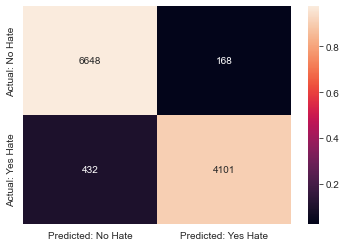

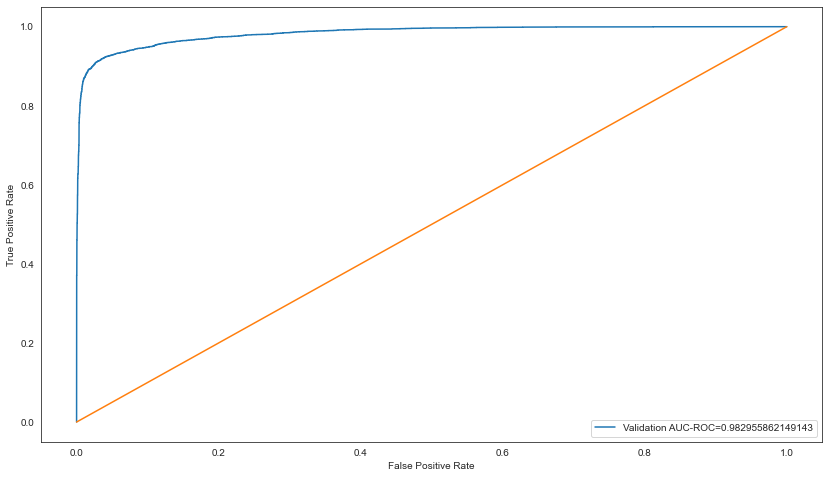

,Actual Label,Predicted_class,Probability
0,0,0,0.076510
1,0,0,0.058656
2,1,1,0.997184
3,0,0,0.004238
4,0,0,0.063963
5,0,0,0.464313
6,0,0,0.445454
7,0,0,0.006957
8,0,0,0.008157
9,1,1,0.997461


In [34]:
lgb_train_new_sm = lgb.Dataset(X_train_new_sm, label=y_train_new_sm)
lgb_test_new_sm = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_sm)


with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-sm'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
        
    lgb_model_sm = lgb.train({**params,**fixed_params}, lgb_train_new_sm,
                          valid_sets=[lgb_train_new_sm, lgb_test_new_sm],
                          valid_names=['train','valid'],
                          num_boost_round=fixed_params["num_boost_round"],
                          early_stopping_rounds=fixed_params["early_stopping_rounds"])

    train_prob = lgb_model_sm.predict(X_train, num_iteration=lgb_model_sm.best_iteration)
    test_prob = lgb_model_sm.predict(X_test, num_iteration=lgb_model_sm.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass, "SMOTE":'sm'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    
    vec_path = './artifacts'
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
print(f"Train ROC AUC LGBM Model Score with SMOTERandUnder: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score with SMOTERandUnder: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)

cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

[LightGBM] [Info] Number of positive: 21799, number of negative: 24221
[LightGBM] [Info] Total Bins 58401
[LightGBM] [Info] Number of data points in the train set: 46020, number of used features: 1018
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473685 -> initscore=-0.105356
[LightGBM] [Info] Start training from score -0.105356
[1]	train's auc: 0.942861	valid's auc: 0.928849
[2]	train's auc: 0.973348	valid's auc: 0.963385
[3]	train's auc: 0.976906	valid's auc: 0.968365
[4]	train's auc: 0.976968	valid's auc: 0.968574
[5]	train's auc: 0.97363	valid's auc: 0.964047
[6]	train's auc: 0.974174	valid's auc: 0.965615
[7]	train's auc: 0.976421	valid's auc: 0.967956
[8]	train's auc: 0.976443	valid's auc: 0.96791
[9]	train's auc: 0.977125	valid's auc: 0.968517
[10]	train's auc: 0.97739	valid's auc: 0.969024
[11]	train's auc: 0.97811	valid's auc: 0.969956
[12]	train's auc: 0.978176	valid's auc: 0.970042
[13]	train's auc: 0.978246	valid's auc: 0.970282
[14]	train's auc: 0.978359	valid's auc: 0

[165]	train's auc: 0.984697	valid's auc: 0.975695
[166]	train's auc: 0.984704	valid's auc: 0.975701
[167]	train's auc: 0.984876	valid's auc: 0.975905
[168]	train's auc: 0.984837	valid's auc: 0.975877
[169]	train's auc: 0.984833	valid's auc: 0.975866
[170]	train's auc: 0.984872	valid's auc: 0.975873
[171]	train's auc: 0.984917	valid's auc: 0.975913
[172]	train's auc: 0.985051	valid's auc: 0.975973
[173]	train's auc: 0.985025	valid's auc: 0.975945
[174]	train's auc: 0.985007	valid's auc: 0.975942
[175]	train's auc: 0.984989	valid's auc: 0.975922
[176]	train's auc: 0.984986	valid's auc: 0.975921
[177]	train's auc: 0.985038	valid's auc: 0.975959
[178]	train's auc: 0.985013	valid's auc: 0.975942
[179]	train's auc: 0.985007	valid's auc: 0.97594
[180]	train's auc: 0.984979	valid's auc: 0.975917
[181]	train's auc: 0.984972	valid's auc: 0.975907
[182]	train's auc: 0.984972	valid's auc: 0.975899
[183]	train's auc: 0.984969	valid's auc: 0.975891
[184]	train's auc: 0.984977	valid's auc: 0.975899
[

[329]	train's auc: 0.988197	valid's auc: 0.977761
[330]	train's auc: 0.988221	valid's auc: 0.97774
[331]	train's auc: 0.988217	valid's auc: 0.977739
[332]	train's auc: 0.988213	valid's auc: 0.977739
[333]	train's auc: 0.988246	valid's auc: 0.977724
[334]	train's auc: 0.988233	valid's auc: 0.977714
[335]	train's auc: 0.988282	valid's auc: 0.977737
[336]	train's auc: 0.988323	valid's auc: 0.97774
[337]	train's auc: 0.988316	valid's auc: 0.977741
[338]	train's auc: 0.9883	valid's auc: 0.97773
[339]	train's auc: 0.988333	valid's auc: 0.977738
[340]	train's auc: 0.98833	valid's auc: 0.977739
[341]	train's auc: 0.988363	valid's auc: 0.977727
[342]	train's auc: 0.988361	valid's auc: 0.977732
[343]	train's auc: 0.988378	valid's auc: 0.977713
[344]	train's auc: 0.988371	valid's auc: 0.977709
[345]	train's auc: 0.988371	valid's auc: 0.977707
[346]	train's auc: 0.98836	valid's auc: 0.9777
[347]	train's auc: 0.988398	valid's auc: 0.977724
[348]	train's auc: 0.988426	valid's auc: 0.977762
[349]	tra

[495]	train's auc: 0.990798	valid's auc: 0.979188
[496]	train's auc: 0.990849	valid's auc: 0.979187
[497]	train's auc: 0.990885	valid's auc: 0.979219
[498]	train's auc: 0.99088	valid's auc: 0.979217
[499]	train's auc: 0.990875	valid's auc: 0.979213
[500]	train's auc: 0.990895	valid's auc: 0.979219
[501]	train's auc: 0.990893	valid's auc: 0.979218
[502]	train's auc: 0.990887	valid's auc: 0.979217
[503]	train's auc: 0.99092	valid's auc: 0.9792
[504]	train's auc: 0.990917	valid's auc: 0.9792
[505]	train's auc: 0.99094	valid's auc: 0.979211
[506]	train's auc: 0.990931	valid's auc: 0.979206
[507]	train's auc: 0.990948	valid's auc: 0.979212
[508]	train's auc: 0.990942	valid's auc: 0.97921
[509]	train's auc: 0.990971	valid's auc: 0.979217
[510]	train's auc: 0.991013	valid's auc: 0.979256
[511]	train's auc: 0.991006	valid's auc: 0.979254
[512]	train's auc: 0.991001	valid's auc: 0.979251
[513]	train's auc: 0.990997	valid's auc: 0.97925
[514]	train's auc: 0.991024	valid's auc: 0.979259
[515]	tra

[660]	train's auc: 0.993351	valid's auc: 0.980717
[661]	train's auc: 0.993351	valid's auc: 0.980719
[662]	train's auc: 0.99335	valid's auc: 0.98072
[663]	train's auc: 0.993381	valid's auc: 0.980743
[664]	train's auc: 0.993404	valid's auc: 0.980744
[665]	train's auc: 0.993406	valid's auc: 0.980746
[666]	train's auc: 0.99342	valid's auc: 0.980766
[667]	train's auc: 0.993448	valid's auc: 0.980766
[668]	train's auc: 0.993478	valid's auc: 0.980779
[669]	train's auc: 0.993502	valid's auc: 0.980759
[670]	train's auc: 0.993537	valid's auc: 0.980803
[671]	train's auc: 0.993535	valid's auc: 0.980804
[672]	train's auc: 0.993533	valid's auc: 0.980804
[673]	train's auc: 0.993533	valid's auc: 0.980804
[674]	train's auc: 0.993532	valid's auc: 0.980803
[675]	train's auc: 0.993529	valid's auc: 0.980804
[676]	train's auc: 0.993527	valid's auc: 0.980803
[677]	train's auc: 0.993523	valid's auc: 0.980799
[678]	train's auc: 0.99355	valid's auc: 0.980849
[679]	train's auc: 0.993584	valid's auc: 0.980853
[680

[825]	train's auc: 0.995051	valid's auc: 0.981788
[826]	train's auc: 0.995051	valid's auc: 0.981787
[827]	train's auc: 0.995051	valid's auc: 0.981789
[828]	train's auc: 0.995052	valid's auc: 0.981789
[829]	train's auc: 0.995052	valid's auc: 0.981791
[830]	train's auc: 0.995052	valid's auc: 0.981792
[831]	train's auc: 0.995047	valid's auc: 0.98179
[832]	train's auc: 0.995048	valid's auc: 0.98179
[833]	train's auc: 0.99506	valid's auc: 0.981794
[834]	train's auc: 0.99506	valid's auc: 0.981796
[835]	train's auc: 0.99506	valid's auc: 0.981795
[836]	train's auc: 0.995056	valid's auc: 0.981793
[837]	train's auc: 0.995066	valid's auc: 0.981807
[838]	train's auc: 0.995067	valid's auc: 0.981807
[839]	train's auc: 0.995082	valid's auc: 0.981808
[840]	train's auc: 0.995094	valid's auc: 0.981811
[841]	train's auc: 0.995107	valid's auc: 0.981811
[842]	train's auc: 0.995129	valid's auc: 0.981818
[843]	train's auc: 0.995129	valid's auc: 0.98182
[844]	train's auc: 0.995129	valid's auc: 0.981819
[845]	

[990]	train's auc: 0.996365	valid's auc: 0.982505
[991]	train's auc: 0.99637	valid's auc: 0.982512
[992]	train's auc: 0.996371	valid's auc: 0.982514
[993]	train's auc: 0.996373	valid's auc: 0.982515
[994]	train's auc: 0.996393	valid's auc: 0.982514
[995]	train's auc: 0.996401	valid's auc: 0.98252
[996]	train's auc: 0.9964	valid's auc: 0.98252
[997]	train's auc: 0.996423	valid's auc: 0.982526
[998]	train's auc: 0.996438	valid's auc: 0.982556
[999]	train's auc: 0.996438	valid's auc: 0.982556
[1000]	train's auc: 0.996437	valid's auc: 0.982555
[1001]	train's auc: 0.996439	valid's auc: 0.982556
[1002]	train's auc: 0.996454	valid's auc: 0.982537
[1003]	train's auc: 0.996462	valid's auc: 0.982554
[1004]	train's auc: 0.99648	valid's auc: 0.982544
[1005]	train's auc: 0.996499	valid's auc: 0.982572
[1006]	train's auc: 0.996517	valid's auc: 0.982581
[1007]	train's auc: 0.996516	valid's auc: 0.982581
[1008]	train's auc: 0.996532	valid's auc: 0.982586
[1009]	train's auc: 0.996549	valid's auc: 0.982

[1152]	train's auc: 0.997321	valid's auc: 0.982863
[1153]	train's auc: 0.997338	valid's auc: 0.982868
[1154]	train's auc: 0.997338	valid's auc: 0.982868
[1155]	train's auc: 0.99735	valid's auc: 0.982871
[1156]	train's auc: 0.997366	valid's auc: 0.982856
[1157]	train's auc: 0.997373	valid's auc: 0.982868
[1158]	train's auc: 0.997373	valid's auc: 0.982868
[1159]	train's auc: 0.997376	valid's auc: 0.982877
[1160]	train's auc: 0.997389	valid's auc: 0.982885
[1161]	train's auc: 0.997391	valid's auc: 0.982885
[1162]	train's auc: 0.997391	valid's auc: 0.982885
[1163]	train's auc: 0.997395	valid's auc: 0.982892
[1164]	train's auc: 0.997401	valid's auc: 0.982888
[1165]	train's auc: 0.997402	valid's auc: 0.982889
[1166]	train's auc: 0.997401	valid's auc: 0.98289
[1167]	train's auc: 0.997402	valid's auc: 0.98289
[1168]	train's auc: 0.997418	valid's auc: 0.982882
[1169]	train's auc: 0.997419	valid's auc: 0.982882
[1170]	train's auc: 0.997421	valid's auc: 0.982885
[1171]	train's auc: 0.997423	valid

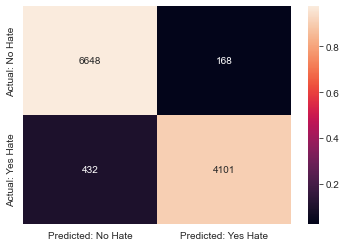

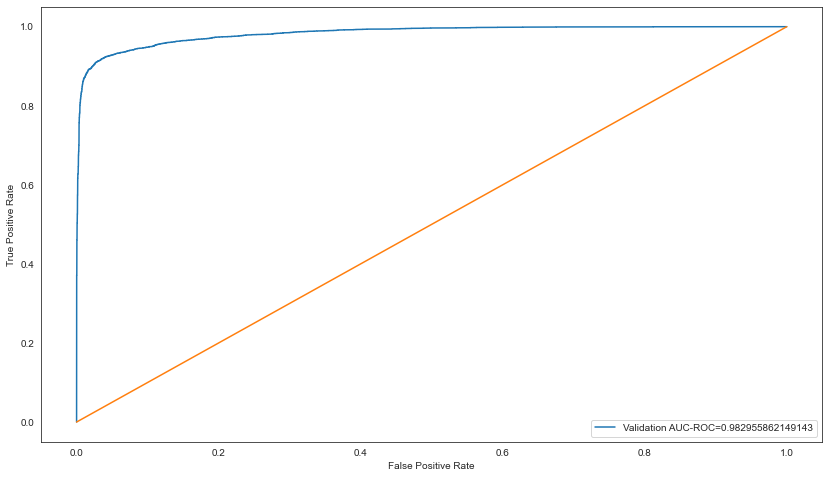

,Actual Label,Predicted_class,Probability
0,0,0,0.076510
1,0,0,0.058656
2,1,1,0.997184
3,0,0,0.004238
4,0,0,0.063963
5,0,0,0.464313
6,0,0,0.445454
7,0,0,0.006957
8,0,0,0.008157
9,1,1,0.997461


In [36]:
lgb_train_new_sm = lgb.Dataset(X_train_new_sm, label=y_train_new_sm)
lgb_test_new_sm = lgb.Dataset(X_test, label=y_test, reference=lgb_train_new_sm)


with mlflow.start_run(experiment_id=experiment_id, run_name='lgb-booster-sm'):
    mlflow.set_tags(tags)
    mlflow.log_params({**params,**fixed_params})
        
    lgb_model_sm = lgb.train({**params,**fixed_params}, lgb_train_new_sm,
                                                            valid_sets=[lgb_train_new_sm, lgb_test_new_sm],
                                                            valid_names=['train','valid'],
                                                            num_boost_round=fixed_params["num_boost_round"],
                                                            early_stopping_rounds=fixed_params["early_stopping_rounds"]
                            )
    

    train_prob = lgb_model_sm.predict(X_train, num_iteration=lgb_model_sm.best_iteration)
    test_prob = lgb_model_sm.predict(X_test, num_iteration=lgb_model_sm.best_iteration)

    y_pred = binary_predict(test_prob)

    train_auc = roc_auc_score(y_train, train_prob)
    test_auc = roc_auc_score(y_test, test_prob)
    misclass = np.mean(y_pred != y_test)*100
    
    mlflow.log_params({"percent-misclassified":misclass, "SMOTE":'sm'})
    mlflow.log_metrics({"train-auc-score":train_auc,
                        "test-auc-score":test_auc})
    
    
    vec_path = './artifacts'
    mlflow.lightgbm.log_model(lgb_model_ada, artifact_path="models")
    with open(os.path.join(vec_path,'vectorizerV7.bin'), 'wb') as f:
        joblib.dump(tfVectorizer, f)
    mlflow.log_artifact(os.path.join(vec_path,'vectorizerV7.bin'), artifact_path="tfVectorizer")
    
print(f"Train ROC AUC LGBM Model Score with SMOTERandUnder: {train_auc:.4f}")
print(f"Test ROC AUC LGBM Model Score with SMOTERandUnder: {test_auc:.4f}")
print("'%' of Misclassified class:", misclass)

cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, test_prob)
plt.show()

out = pd.DataFrame(y_test[0:30])
out = out.rename(columns={0:'Actual Label'})
out['Predicted_class'] = y_pred[0:30]
out['Probability'] = test_prob[0:30]
out

**We will consider the model with no SMOTE because of the low '%' of Misclassified class**

Final LGBMClassifer ROC AUC Score : 0.9830
'%' of Misclassified class: 5.330866155608423


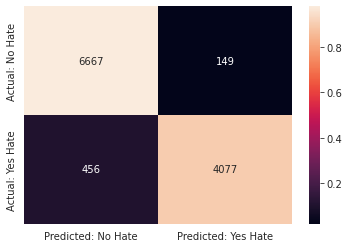

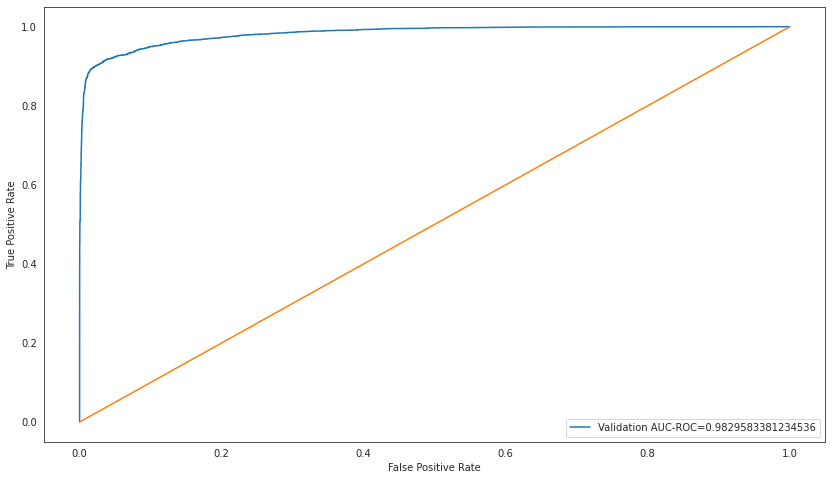

In [40]:
# final_model = make_pipeline(StandardScaler(), lgb.LGBMClassifier(n_estimators=400, reg_alpha=0.1, learning_rate=0.1,
#                                                              objective='binary',
#                                                              class_weight={0:1,1:1}))

# final_model.fit(X_train_new, y_train_new)
# pred = final_model.predict_proba(X_test)[:, 1]
# y_pred = final_model.predict(X_test)
# auc = roc_auc_score(y_test, pred)
# print(f"Final LGBMClassifer ROC AUC Score : {roc_auc_score(y_test, pred):.4f}")
# print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
# cm = confusion_matrix(y_test, y_pred)
# confusion_matrix_plot(cm)
# roc_auc_curve(y_test, pred)
# plt.show()

In [30]:
# sns.distplot(y_pred, label='prediction')
# sns.distplot(y_train_new, label='actual')
# plt.legend()
# plt.show()

# Serialize Tfidf Vectorizer & the Final Model pipeline

In [43]:
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV6.bin', 'wb') as f:
#     joblib.dump((tfVectorizer, final_model), f)

In [44]:
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/vectorizers/vectorizerV5.bin', 'wb') as f:
#     joblib.dump(tfVectorizer, f)
    
# with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV5.bin', 'wb') as f:
#     joblib.dump(final_model, f)